# November 17th, 2021

**Motivation**: Figures for Thursday meeting (Nov 18th). <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
from scipy.ndimage import gaussian_filter

def show_h(proj_h, proj_hr, cmap='icefire', interp='antialiased'):
    fig, axes = create_figure(1, 4, (13., 3), gridspec_kw={'width_ratios': [1.8, 1, 1, 1.8]})

    x2plt = proj_h['parcel2d-flat'].squeeze()
    x2plt = gaussian_filter(x2plt, sigma=1)
    x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
    im = axes[0].imshow(x2plt, cmap=cmap, interpolation=interp)
    plt.colorbar(im, ax=axes[0], shrink=0.4)

    x2plt = proj_h['parcel2d-top'].squeeze()
    x2plt = gaussian_filter(x2plt, sigma=1)
    x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
    axes[1].imshow(x2plt, cmap=cmap, interpolation=interp)

    x2plt = proj_hr['parcel2d-top'].squeeze()
    x2plt = gaussian_filter(x2plt, sigma=1)
    x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
    axes[2].imshow(x2plt, cmap=cmap, interpolation=interp)

    x2plt = proj_hr['parcel2d-flat'].squeeze()
    x2plt = gaussian_filter(x2plt, sigma=1)
    x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
    im = axes[3].imshow(x2plt, cmap=cmap, interpolation=interp)
    plt.colorbar(im, ax=axes[3], shrink=0.4)

    remove_ticks(axes)
    plt.show()
    
    
def get_h(pi_arr, approach='pi_animals'):
    if approach == 'pi_animals':
        pi = bn.nanmean(pi_arr, -3)
        pi = bn.nanmean(bn.nanmean(pi, 2), 1)
        h = sp_stats.entropy(pi, axis=-2) / np.log(pi.shape[-2])
        h = bn.nanmean(h, 0)
        hr = sp_stats.rankdata(h)
    elif approach == 'avg_pi_first':
        pi = bn.nanmean(pi_arr, -3)
        pi = bn.nanmean(bn.nanmean(bn.nanmean(pi, 2), 1), 0)
        h = sp_stats.entropy(pi, axis=0) / np.log(len(pi))
        hr = sp_stats.rankdata(h)
    elif approach == 'no_pi_avg':
        h_arr = sp_stats.entropy(pi_arr, axis=-2) / np.log(pi_arr.shape[-2])
        h = bn.nanmean(h_arr, -3)
        h = bn.nanmean(bn.nanmean(bn.nanmean(h, 2), 1), 0)
    hr = sp_stats.rankdata(h)
    proj_h = gr.project_vec(h)
    proj_hr = gr.project_vec(hr)
    return h, hr, proj_h, proj_hr

In [3]:
mice = Mice((64, 2))
mice.setup_func_data('rest')

In [8]:
props_base = {
    'num_k': 4,
    'mice': mice,
    'task': 'rest',
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'prepare_data': False,
    'verbose': False,
}
props_ca = {'perc': 'p20-sample', **props_base}
props_bold = {'perc': 'p30-sample', **props_base}

In [9]:
gr = Group(mode='ca2', centroids_from='all', **props_ca)
group_ca = gr.fit_group(skip_align=False)

gr = Group(mode='bold-lite', centroids_from='all', **props_bold)
group_bold = gr.fit_group(skip_align=False)

In [10]:
bins = np.linspace(0.2, 1.0, 5)

statistic = mk_statistic_fn(
    bins=bins,
    est_sub=bn.nanmean,
    est_ses=bn.nanmean,
    est_run=bn.nanmean,
    est_seed=bn.nanmedian,
    scipy=False,
)

In [11]:
output_ca = statistic(group_ca['gam_run'])
output_bold = statistic(group_bold['gam_run'])

In [12]:
_disj = gr.get_disjoint_community(output_ca['pi_group'], to_vec=True)
pi_avg_with_disj_ca = np.concatenate([output_ca['pi_group'], np.expand_dims(_disj, 0)])
proj_ca = gr.project_vec(pi_avg_with_disj_ca)

_disj = gr.get_disjoint_community(output_bold['pi_group'], to_vec=True)
pi_avg_with_disj_bold = np.concatenate([output_bold['pi_group'], np.expand_dims(_disj, 0)])
proj_bold = gr.project_vec(pi_avg_with_disj_bold)

In [18]:
fig, _ = gr.show(
    proj_bold, proj_ca,
    labels=('BOLD-Lite', r'Ca$^{2+}$'),
    cmaps=('rocket', 'mako'),
    display=False,
)
sup = f"BOLD-Lite:   k{props_bold.get('num_k')} / {props_bold.get('perc')},          "
sup += r"CA$^{2+}$:   " + f"k{props_ca.get('num_k')} / {props_ca.get('perc')}"
sup = fig.suptitle(sup, fontsize=18, y=1.02)

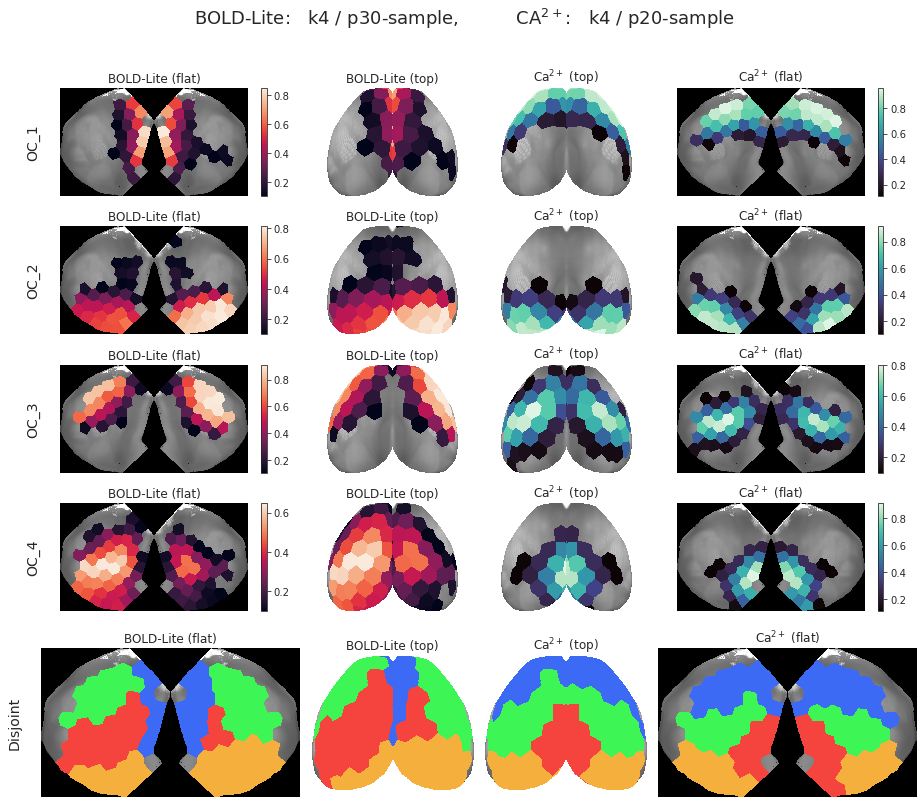

In [19]:
fig

<AxesSubplot:ylabel='Count'>

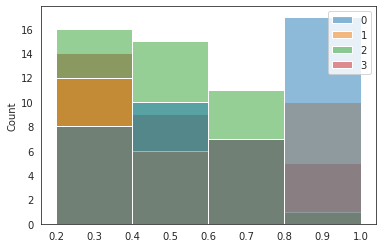

In [21]:
sns.histplot(output_ca['pi_group'].T, bins=bins)

## Now seed filtering

In [124]:
gr = Group(mode='ca2', centroids_from='all', **props_ca)
# gr = Group(mode='bold-lite', centroids_from='all', **props_bold)

In [125]:
ner = Normalizer()

In [126]:
sub = 6
ses = 2
run = 7
key = mice.get_key(sub, ses, run)

sv_ca = SVINET(key=key, mode='ca2', **props_ca).load_results()
sv_bold = SVINET(key=key, mode='bold-lite', **props_bold).load_results()

sv_ca.pi.shape, sv_bold.pi.shape

((4, 98), (4, 98))

In [127]:
key

'sub-SLC06_ses-2_run-7'

In [128]:
num_seeds, num_k, num_nodes = sv_ca.gam_all.shape
num_seeds, num_k, num_nodes

(500, 4, 98)

In [129]:
nonan = np.where(np.isnan(sv_ca.gam_all).sum(0).sum(0) == 0)[0]
len(nonan)

88

In [130]:
data = sv_ca.gam_all.reshape(-1, num_nodes)
data.shape

(2000, 98)

In [131]:
centroids = np_nans((num_k, num_nodes))
_centroids, _ = fit_kmeans(
    data=data[:, nonan],
    n_clusters=num_k,
    match_metric='euclidean',
    random_state=mice.cfg.random_state,
)
centroids[:, nonan] = _centroids
centroids.shape

(4, 98)

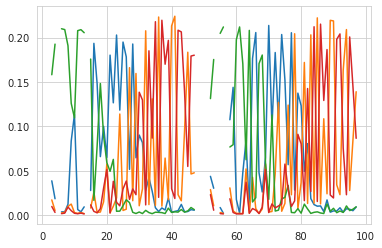

In [132]:
plt.plot(centroids.T);

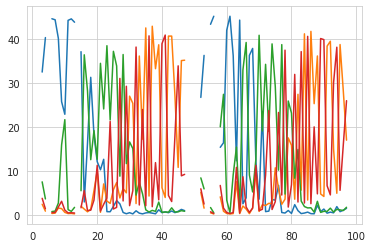

In [133]:
plt.plot(bn.nanmean(sv_ca.gam_all, 0).T);

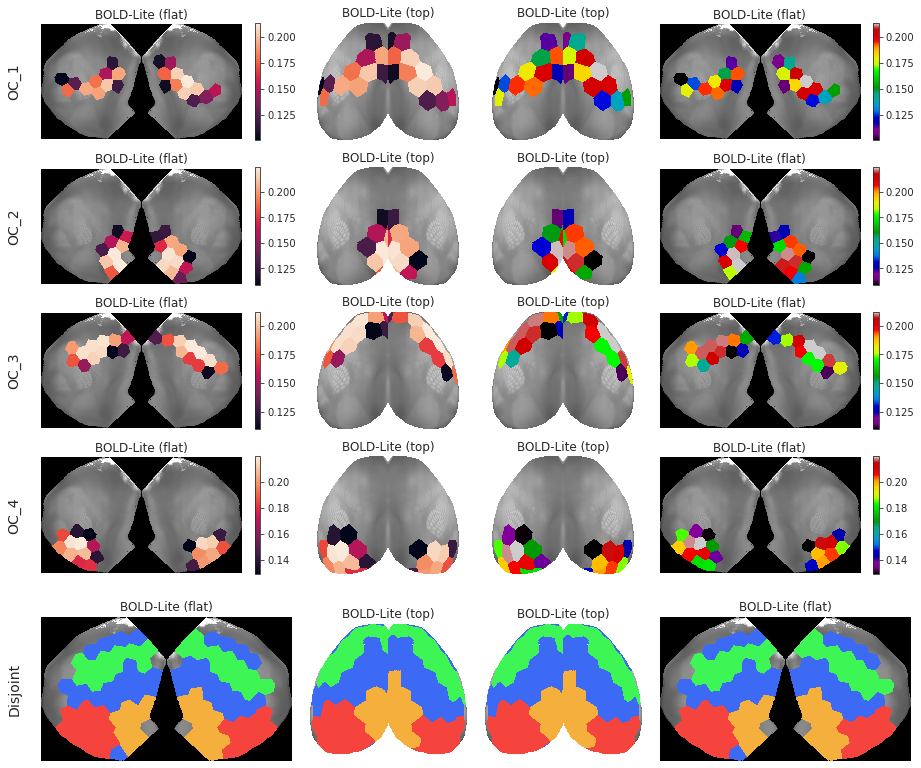

In [134]:
_disj = gr.get_disjoint_community(centroids, to_vec=True)
ctrds = np.concatenate([centroids, np.expand_dims(_disj, 0)])
proj_ctrds = gr.project_vec(ctrds)
_ = gr.show(proj_ctrds)

In [135]:
gam_normed = np.zeros_like(sv_ca.gam_all)

for i in range(num_seeds):
    a = ner.fit_transform(sv_ca.gam_all[i][:, nonan])
    gam_normed[i][:, nonan] = a

In [136]:
dists = np.zeros((num_seeds, num_k, num_k))
dists_mean = np.zeros(num_seeds)
for seed_i in range(num_seeds):
    d = sp_dist.cdist(
        XA=centroids[:, nonan],
        XB=gam_normed[seed_i][:, nonan],
        metric='euclidean',
    )
    dists[seed_i] = d
    dists_mean[seed_i] = np.diag(d).mean()

In [137]:
dists_cos = np.zeros((num_seeds, num_k, num_k))
dists_cos_mean = np.zeros(num_seeds)
for seed_i in range(num_seeds):
    d = sp_dist.cdist(
        XA=centroids[:, nonan],
        XB=gam_normed[seed_i][:, nonan],
        metric='cosine',
    )
    dists_cos[seed_i] = d
    dists_cos_mean[seed_i] = np.diag(d).mean()

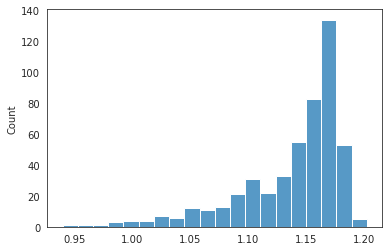

In [138]:
sns.histplot(dists_mean);

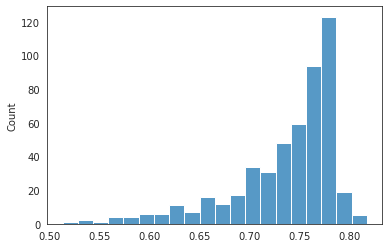

In [139]:
sns.histplot(dists_cos_mean);

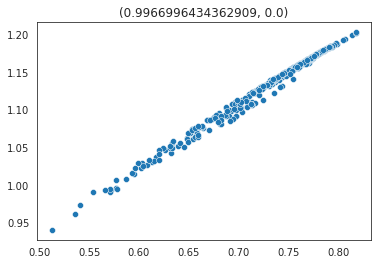

In [140]:
sns.scatterplot(dists_cos_mean, dists_mean)
plt.title(sp_stats.pearsonr(dists_cos_mean, dists_mean));

In [141]:
x = sv_ca.gam_all[np.argmin(dists_cos_mean)]
y = sv_ca.gam_all[np.argmax(dists_cos_mean)]

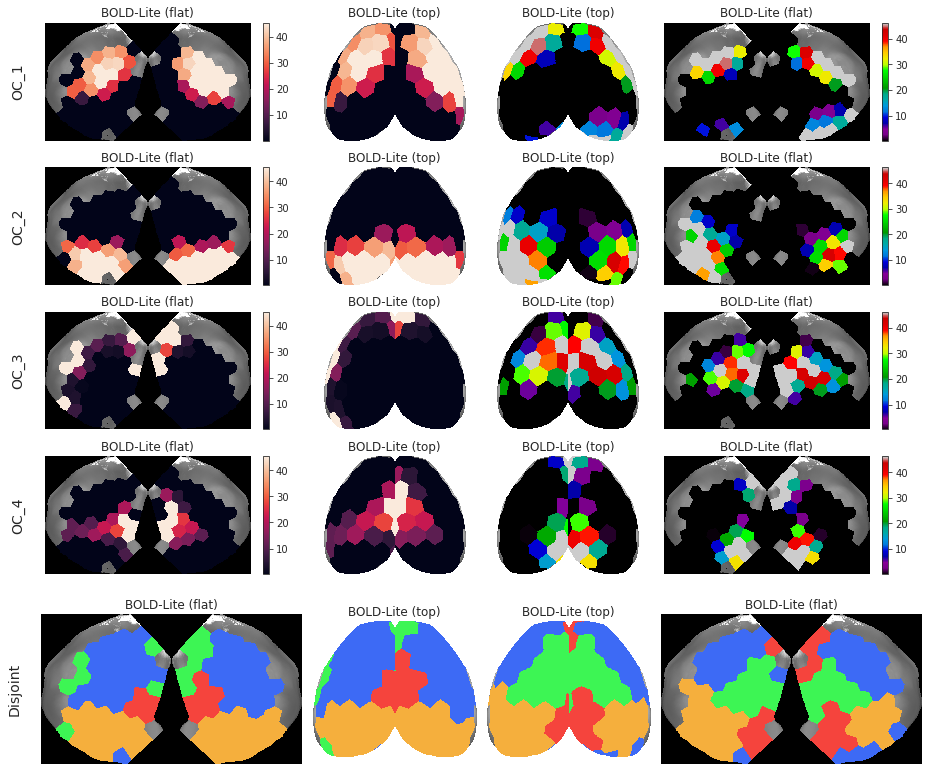

In [142]:
_disj = gr.get_disjoint_community(x, to_vec=True)
x = np.concatenate([x, np.expand_dims(_disj, 0)])
proj_x = gr.project_vec(x)

_disj = gr.get_disjoint_community(y, to_vec=True)
y = np.concatenate([y, np.expand_dims(_disj, 0)])
proj_y = gr.project_vec(y)

_ = gr.show(proj_x, proj_y)

In [143]:
n_selected = 50
selected_seeds = np.argsort(dists_cos_mean)[:n_selected]

<AxesSubplot:ylabel='Count'>

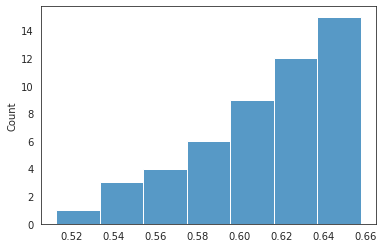

In [144]:
sns.histplot(dists_cos_mean[selected_seeds])

In [145]:
x = bn.nanmean(sv_ca.pi_all[np.argsort(dists_cos_mean)[:50]], 0)
y = bn.nanmean(sv_ca.pi_all[np.argsort(dists_cos_mean)[::-1][:50]], 0)

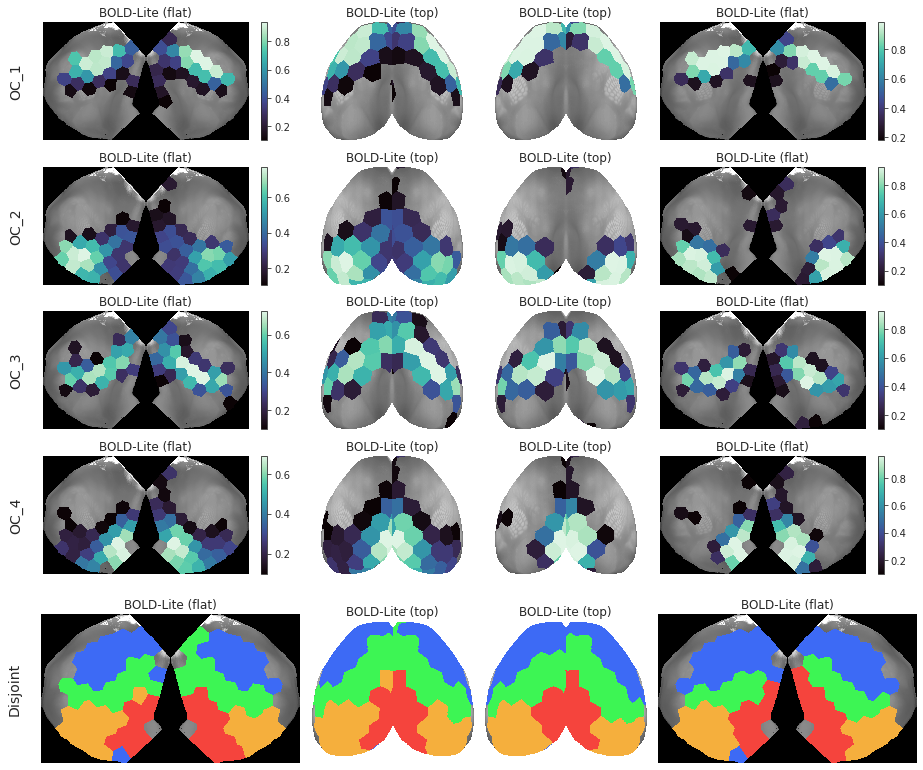

In [146]:
_disj = gr.get_disjoint_community(x, to_vec=True)
x = np.concatenate([x, np.expand_dims(_disj, 0)])
proj_x = gr.project_vec(x)

_disj = gr.get_disjoint_community(y, to_vec=True)
y = np.concatenate([y, np.expand_dims(_disj, 0)])
proj_y = gr.project_vec(y)

_ = gr.show(proj_x, proj_y, cmaps=('mako', 'mako'))

### BOLD

In [147]:
# gr = Group(mode='ca2', centroids_from='all', **props_ca)
gr = Group(mode='bold-lite', centroids_from='all', **props_bold)

In [148]:
ner = Normalizer()

In [149]:
sub = 6
ses = 2
run = 7
key = mice.get_key(sub, ses, run)

# sv_ca = SVINET(key=key, mode='ca2', **props_ca).load_results()
sv_bold = SVINET(key=key, mode='bold-lite', **props_bold).load_results()

sv_ca.pi.shape, sv_bold.pi.shape

((4, 98), (4, 98))

In [150]:
key

'sub-SLC06_ses-2_run-7'

In [151]:
num_seeds, num_k, num_nodes = sv_bold.gam_all.shape
num_seeds, num_k, num_nodes

(500, 4, 98)

In [152]:
nonan = np.where(np.isnan(sv_bold.gam_all).sum(0).sum(0) == 0)[0]
len(nonan)

95

In [153]:
data = sv_bold.gam_all.reshape(-1, num_nodes)
data.shape

(2000, 98)

In [154]:
centroids = np_nans((num_k, num_nodes))
_centroids, _ = fit_kmeans(
    data=data[:, nonan],
    n_clusters=num_k,
    match_metric='euclidean',
    random_state=mice.cfg.random_state,
)
centroids[:, nonan] = _centroids
centroids.shape

(4, 98)

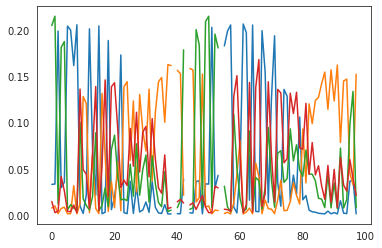

In [155]:
plt.plot(centroids.T);

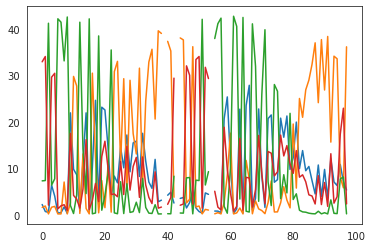

In [156]:
plt.plot(bn.nanmean(sv_bold.gam_all, 0).T);

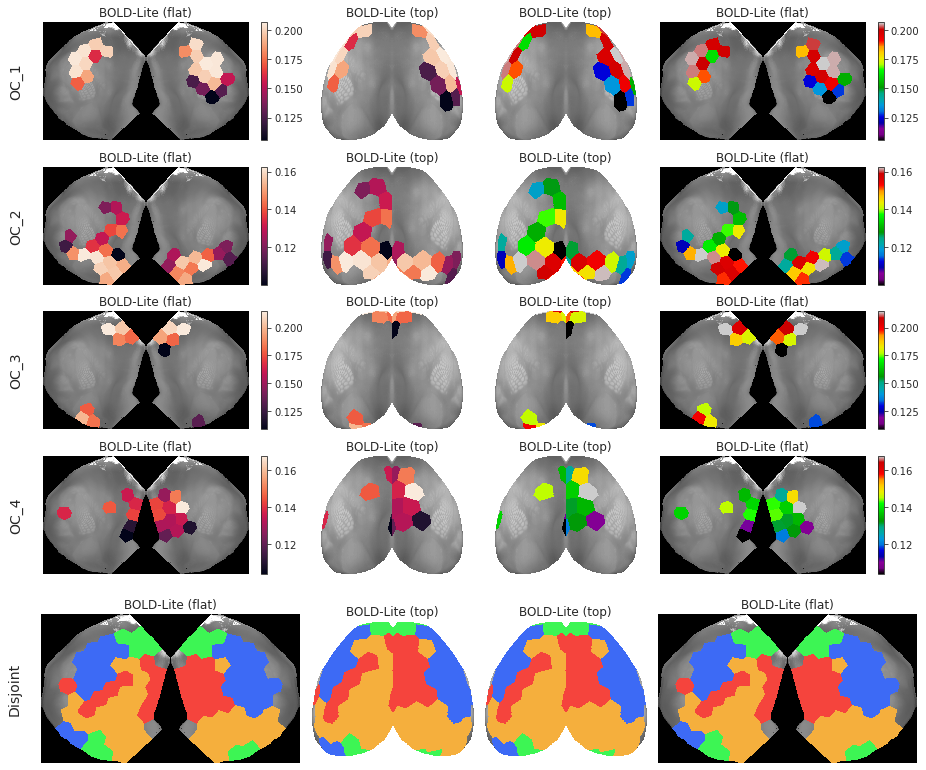

In [157]:
_disj = gr.get_disjoint_community(centroids, to_vec=True)
ctrds = np.concatenate([centroids, np.expand_dims(_disj, 0)])
proj_ctrds = gr.project_vec(ctrds)
_ = gr.show(proj_ctrds)

In [158]:
gam_normed = np.zeros_like(sv_bold.gam_all)

for i in range(num_seeds):
    a = ner.fit_transform(sv_bold.gam_all[i][:, nonan])
    gam_normed[i][:, nonan] = a

In [159]:
dists = np.zeros((num_seeds, num_k, num_k))
dists_mean = np.zeros(num_seeds)
for seed_i in range(num_seeds):
    d = sp_dist.cdist(
        XA=centroids[:, nonan],
        XB=gam_normed[seed_i][:, nonan],
        metric='euclidean',
    )
    dists[seed_i] = d
    dists_mean[seed_i] = np.diag(d).mean()

In [160]:
dists_cos = np.zeros((num_seeds, num_k, num_k))
dists_cos_mean = np.zeros(num_seeds)
for seed_i in range(num_seeds):
    d = sp_dist.cdist(
        XA=centroids[:, nonan],
        XB=gam_normed[seed_i][:, nonan],
        metric='cosine',
    )
    dists_cos[seed_i] = d
    dists_cos_mean[seed_i] = np.diag(d).mean()

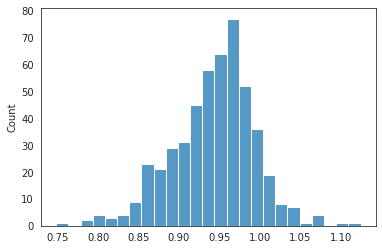

In [161]:
sns.histplot(dists_mean);

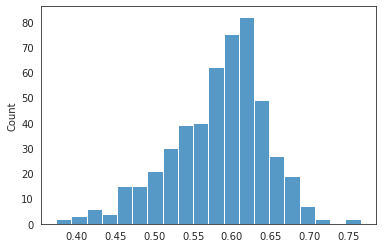

In [162]:
sns.histplot(dists_cos_mean);

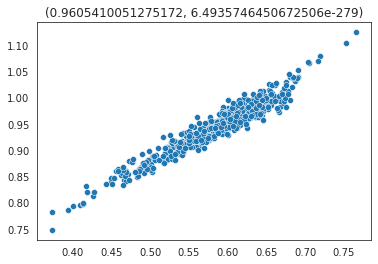

In [163]:
sns.scatterplot(dists_cos_mean, dists_mean)
plt.title(sp_stats.pearsonr(dists_cos_mean, dists_mean));

In [164]:
x = sv_bold.pi_all[np.argmin(dists_cos_mean)]
y = sv_bold.pi_all[np.argmax(dists_cos_mean)]

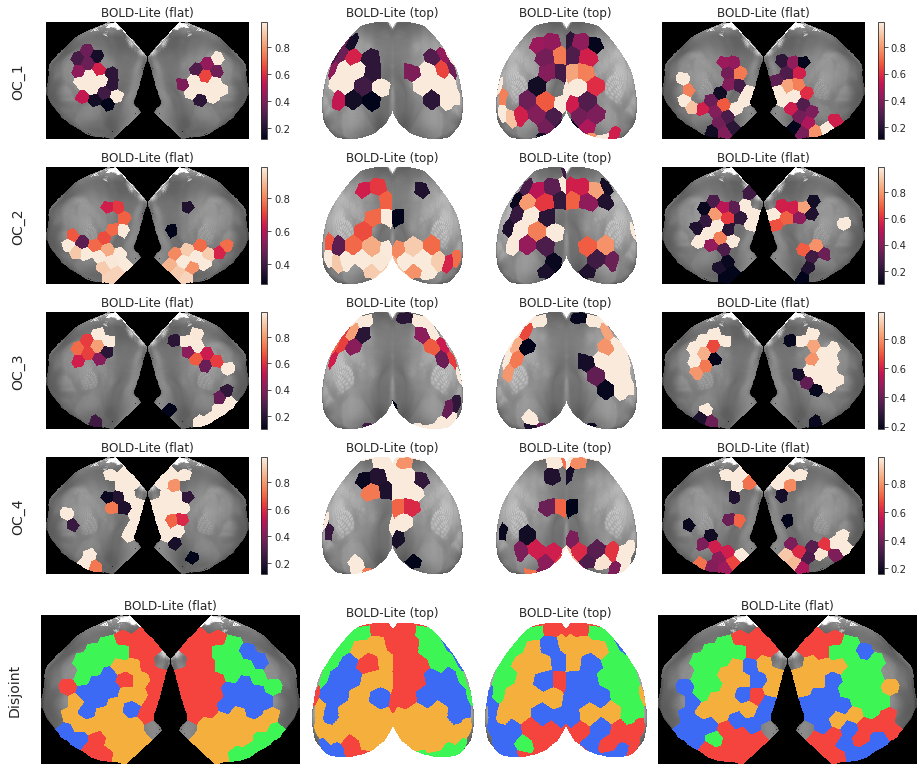

In [165]:
_disj = gr.get_disjoint_community(x, to_vec=True)
x = np.concatenate([x, np.expand_dims(_disj, 0)])
proj_x = gr.project_vec(x)

_disj = gr.get_disjoint_community(y, to_vec=True)
y = np.concatenate([y, np.expand_dims(_disj, 0)])
proj_y = gr.project_vec(y)

_ = gr.show(proj_x, proj_y, cmaps=('rocket', 'rocket'))

In [166]:
n_selected = 50
selected_seeds = np.argsort(dists_cos_mean)[:n_selected]

<AxesSubplot:ylabel='Count'>

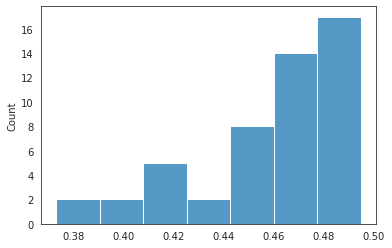

In [167]:
sns.histplot(dists_cos_mean[selected_seeds])

In [168]:
x = bn.nanmean(sv_bold.pi_all[np.argsort(dists_cos_mean)[:50]], 0)
y = bn.nanmean(sv_bold.pi_all[np.argsort(dists_cos_mean)[::-1][:50]], 0)

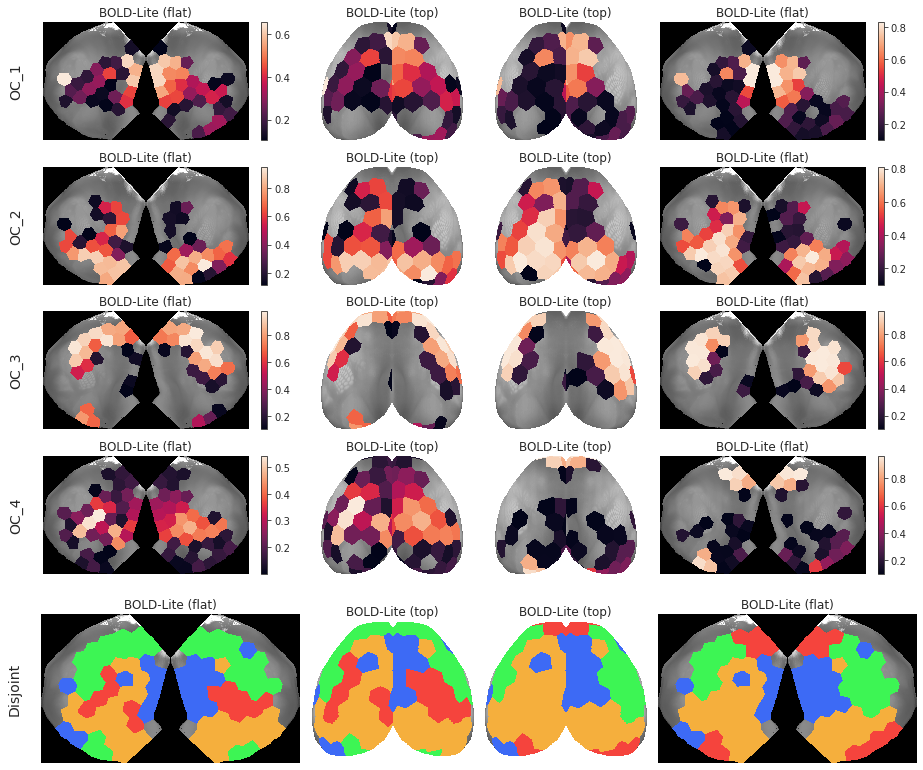

In [169]:
_disj = gr.get_disjoint_community(x, to_vec=True)
x = np.concatenate([x, np.expand_dims(_disj, 0)])
proj_x = gr.project_vec(x)

_disj = gr.get_disjoint_community(y, to_vec=True)
y = np.concatenate([y, np.expand_dims(_disj, 0)])
proj_y = gr.project_vec(y)

_ = gr.show(proj_x, proj_y, cmaps=('rocket', 'rocket'))

### Now at session level

In [170]:
mice = Mice((64, 2))
mice.setup_func_data('rest')

In [171]:
props_base = {
    'num_k': 4,
    'mice': mice,
    'task': 'rest',
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'prepare_data': False,
    'verbose': False,
}
props_ca = {'perc': 'p10-sample', **props_base}
props_bold = {'perc': 'p10-sample', **props_base}

In [172]:
gr = Group(mode='ca2', centroids_from='all', **props_ca)
# gr = Group(mode='bold-lite', centroids_from='all', **props_bold)

In [173]:
ner = Normalizer()

In [174]:
sub = 6
ses = 2
key = mice.get_key(sub, ses)

sv_ca = SVINET(key=key, mode='ca2', **props_ca).load_results()
sv_bold = SVINET(key=key, mode='bold-lite', **props_bold).load_results()

sv_ca.pi.shape, sv_bold.pi.shape

((4, 98), (4, 98))

In [175]:
key

'sub-SLC06_ses-2'

In [176]:
num_seeds, num_k, num_nodes = sv_ca.gam_all.shape
num_seeds, num_k, num_nodes

(500, 4, 98)

In [177]:
nonan = np.where(np.isnan(sv_ca.gam_all).sum(0).sum(0) == 0)[0]
len(nonan)

92

In [178]:
data = sv_ca.gam_all.reshape(-1, num_nodes)
data.shape

(2000, 98)

In [179]:
centroids = np_nans((num_k, num_nodes))
_centroids, _ = fit_kmeans(
    data=data[:, nonan],
    n_clusters=num_k,
    match_metric='euclidean',
    random_state=mice.cfg.random_state,
)
centroids[:, nonan] = _centroids
centroids.shape

(4, 98)

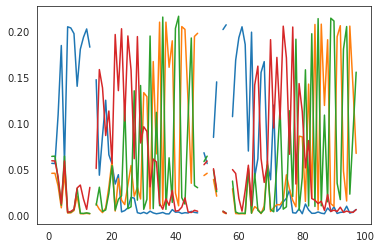

In [180]:
plt.plot(centroids.T);

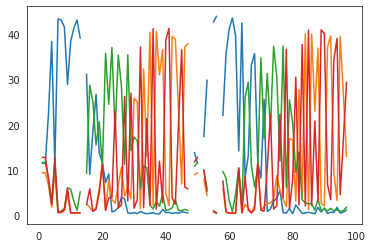

In [181]:
plt.plot(bn.nanmean(sv_ca.gam_all, 0).T);

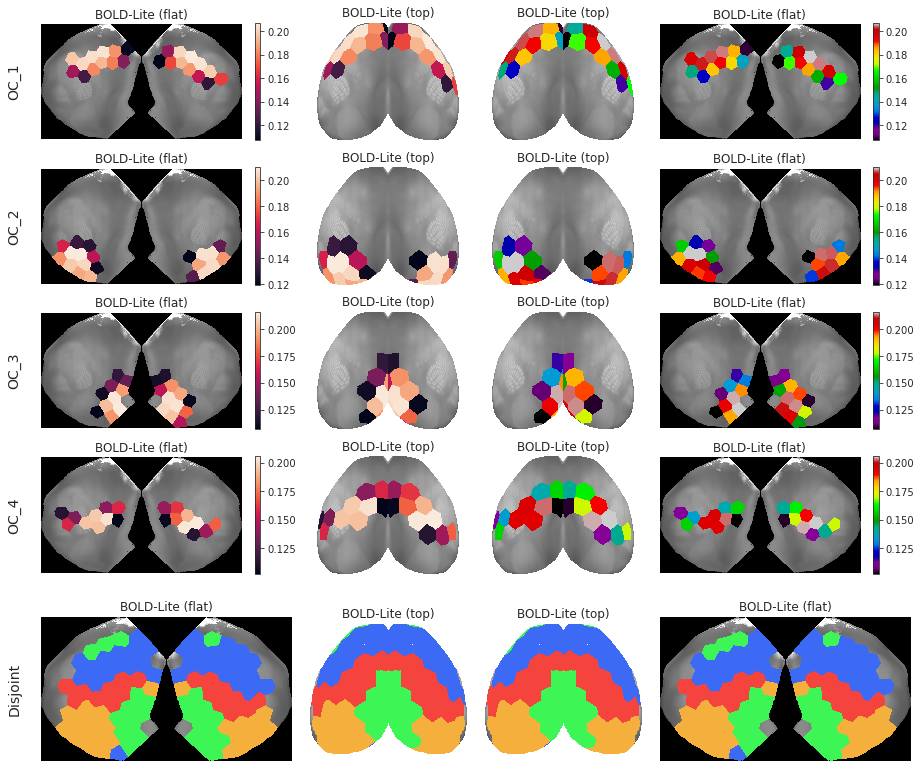

In [182]:
_disj = gr.get_disjoint_community(centroids, to_vec=True)
ctrds = np.concatenate([centroids, np.expand_dims(_disj, 0)])
proj_ctrds = gr.project_vec(ctrds)
_ = gr.show(proj_ctrds)

In [183]:
gam_normed = np.zeros_like(sv_ca.gam_all)

for i in range(num_seeds):
    a = ner.fit_transform(sv_ca.gam_all[i][:, nonan])
    gam_normed[i][:, nonan] = a

In [184]:
dists = np.zeros((num_seeds, num_k, num_k))
dists_mean = np.zeros(num_seeds)
for seed_i in range(num_seeds):
    d = sp_dist.cdist(
        XA=centroids[:, nonan],
        XB=gam_normed[seed_i][:, nonan],
        metric='euclidean',
    )
    dists[seed_i] = d
    dists_mean[seed_i] = np.diag(d).mean()

In [185]:
dists_cos = np.zeros((num_seeds, num_k, num_k))
dists_cos_mean = np.zeros(num_seeds)
for seed_i in range(num_seeds):
    d = sp_dist.cdist(
        XA=centroids[:, nonan],
        XB=gam_normed[seed_i][:, nonan],
        metric='cosine',
    )
    dists_cos[seed_i] = d
    dists_cos_mean[seed_i] = np.diag(d).mean()

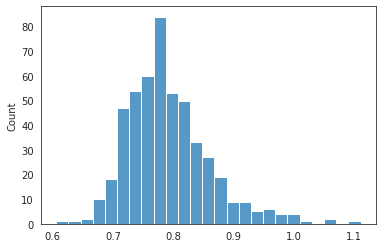

In [186]:
sns.histplot(dists_mean);

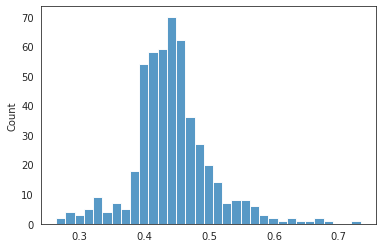

In [187]:
sns.histplot(dists_cos_mean);

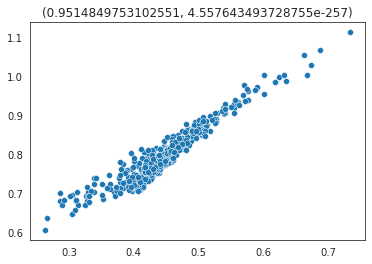

In [188]:
sns.scatterplot(dists_cos_mean, dists_mean)
plt.title(sp_stats.pearsonr(dists_cos_mean, dists_mean));

In [189]:
x = sv_ca.pi_all[np.argmin(dists_cos_mean)]
y = sv_ca.pi_all[np.argmax(dists_cos_mean)]

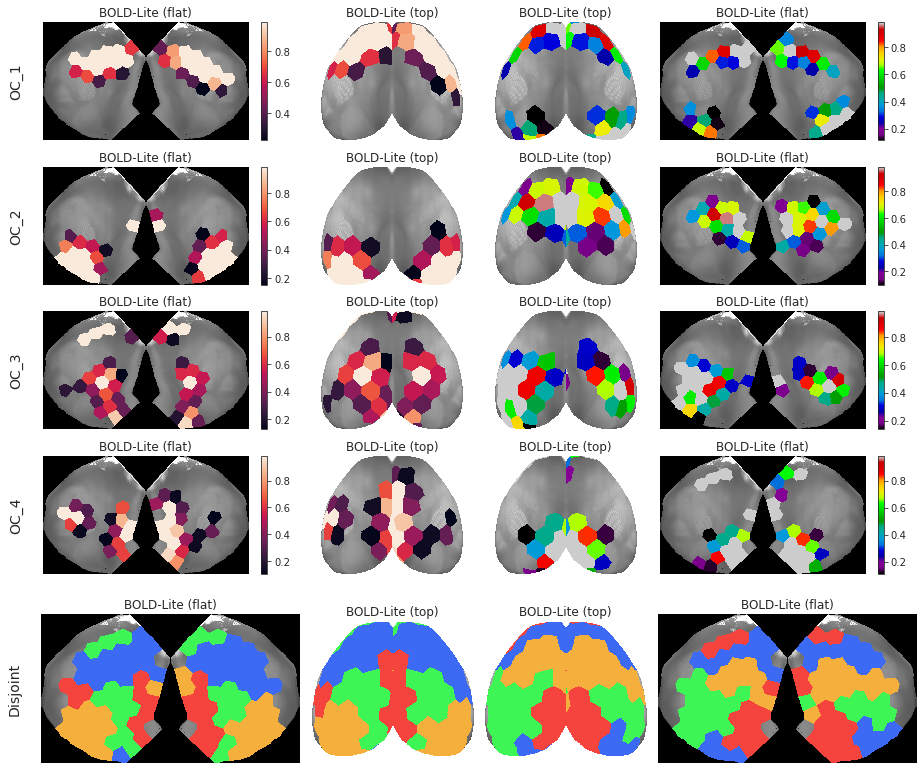

In [190]:
_disj = gr.get_disjoint_community(x, to_vec=True)
x = np.concatenate([x, np.expand_dims(_disj, 0)])
proj_x = gr.project_vec(x)

_disj = gr.get_disjoint_community(y, to_vec=True)
y = np.concatenate([y, np.expand_dims(_disj, 0)])
proj_y = gr.project_vec(y)

_ = gr.show(proj_x, proj_y)

In [191]:
n_selected = 50
selected_seeds = np.argsort(dists_cos_mean)[:n_selected]

<AxesSubplot:ylabel='Count'>

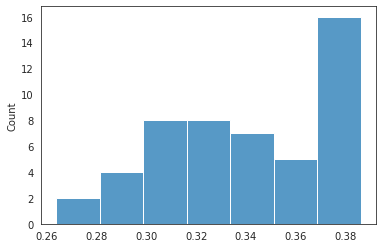

In [192]:
sns.histplot(dists_cos_mean[selected_seeds])

In [193]:
x = bn.nanmean(sv_ca.pi_all[np.argsort(dists_cos_mean)[:50]], 0)
y = bn.nanmean(sv_ca.pi_all[np.argsort(dists_cos_mean)[::-1][:50]], 0)

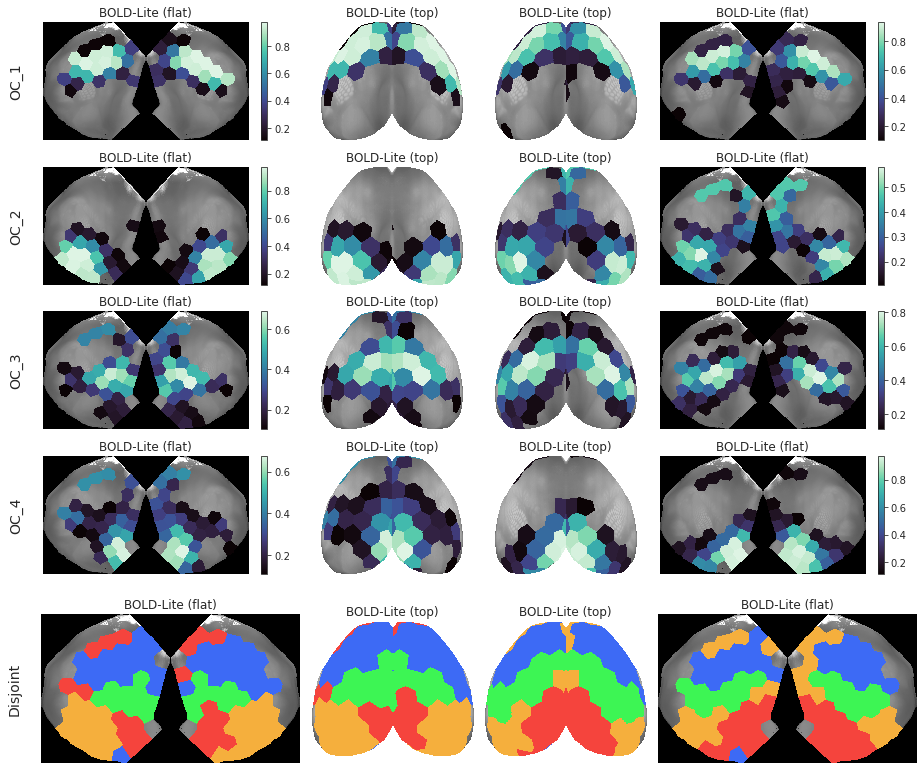

In [194]:
_disj = gr.get_disjoint_community(x, to_vec=True)
x = np.concatenate([x, np.expand_dims(_disj, 0)])
proj_x = gr.project_vec(x)

_disj = gr.get_disjoint_community(y, to_vec=True)
y = np.concatenate([y, np.expand_dims(_disj, 0)])
proj_y = gr.project_vec(y)

_ = gr.show(proj_x, proj_y, cmaps=('mako', 'mako'))

### BOLD

In [195]:
# gr = Group(mode='ca2', centroids_from='all', **props_ca)
gr = Group(mode='bold-lite', centroids_from='all', **props_bold)

In [196]:
ner = Normalizer()

In [197]:
sub = 6
ses = 2
key = mice.get_key(sub, ses)
print(key)

# sv_ca = SVINET(key=key, mode='ca2', **props_ca).load_results()
sv_bold = SVINET(key=key, mode='bold-lite', **props_bold).load_results()

sv_ca.pi.shape, sv_bold.pi.shape

sub-SLC06_ses-2

((4, 98), (4, 98))

In [198]:
num_seeds, num_k, num_nodes = sv_bold.gam_all.shape
num_seeds, num_k, num_nodes

(500, 4, 98)

In [199]:
nonan = np.where(np.isnan(sv_bold.gam_all).sum(0).sum(0) == 0)[0]
len(nonan)

95

In [200]:
data = sv_bold.gam_all.reshape(-1, num_nodes)
data.shape

(2000, 98)

In [201]:
centroids = np_nans((num_k, num_nodes))
_centroids, _ = fit_kmeans(
    data=data[:, nonan],
    n_clusters=num_k,
    match_metric='euclidean',
    random_state=mice.cfg.random_state,
)
centroids[:, nonan] = _centroids
centroids.shape

(4, 98)

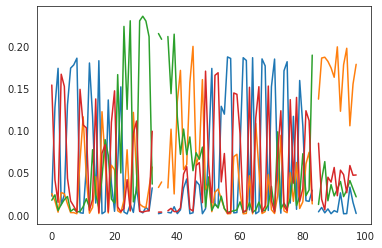

In [202]:
plt.plot(centroids.T);

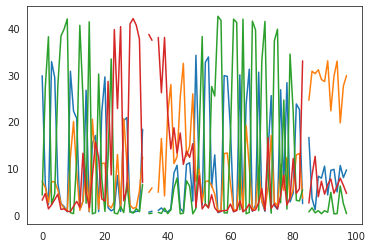

In [203]:
plt.plot(bn.nanmean(sv_bold.gam_all, 0).T);

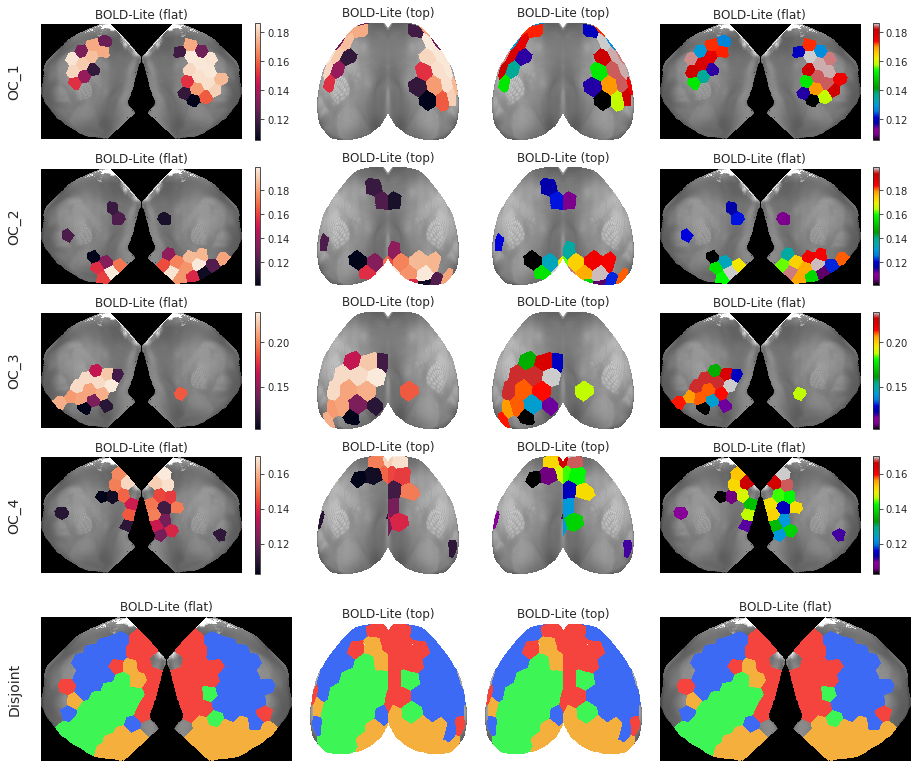

In [204]:
_disj = gr.get_disjoint_community(centroids, to_vec=True)
ctrds = np.concatenate([centroids, np.expand_dims(_disj, 0)])
proj_ctrds = gr.project_vec(ctrds)
_ = gr.show(proj_ctrds)

In [205]:
gam_normed = np.zeros_like(sv_bold.gam_all)

for i in range(num_seeds):
    a = ner.fit_transform(sv_bold.gam_all[i][:, nonan])
    gam_normed[i][:, nonan] = a

In [206]:
dists = np.zeros((num_seeds, num_k, num_k))
dists_mean = np.zeros(num_seeds)
for seed_i in range(num_seeds):
    d = sp_dist.cdist(
        XA=centroids[:, nonan],
        XB=gam_normed[seed_i][:, nonan],
        metric='euclidean',
    )
    dists[seed_i] = d
    dists_mean[seed_i] = np.diag(d).mean()

In [207]:
dists_cos = np.zeros((num_seeds, num_k, num_k))
dists_cos_mean = np.zeros(num_seeds)
for seed_i in range(num_seeds):
    d = sp_dist.cdist(
        XA=centroids[:, nonan],
        XB=gam_normed[seed_i][:, nonan],
        metric='cosine',
    )
    dists_cos[seed_i] = d
    dists_cos_mean[seed_i] = np.diag(d).mean()

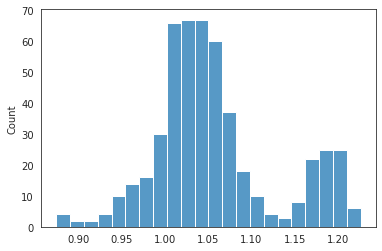

In [208]:
sns.histplot(dists_mean);

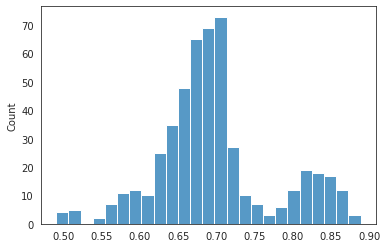

In [209]:
sns.histplot(dists_cos_mean);

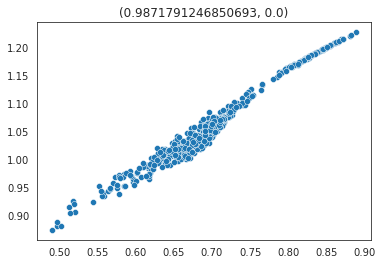

In [210]:
sns.scatterplot(dists_cos_mean, dists_mean)
plt.title(sp_stats.pearsonr(dists_cos_mean, dists_mean));

In [211]:
x = sv_bold.pi_all[np.argmin(dists_cos_mean)]
y = sv_bold.pi_all[np.argmax(dists_cos_mean)]

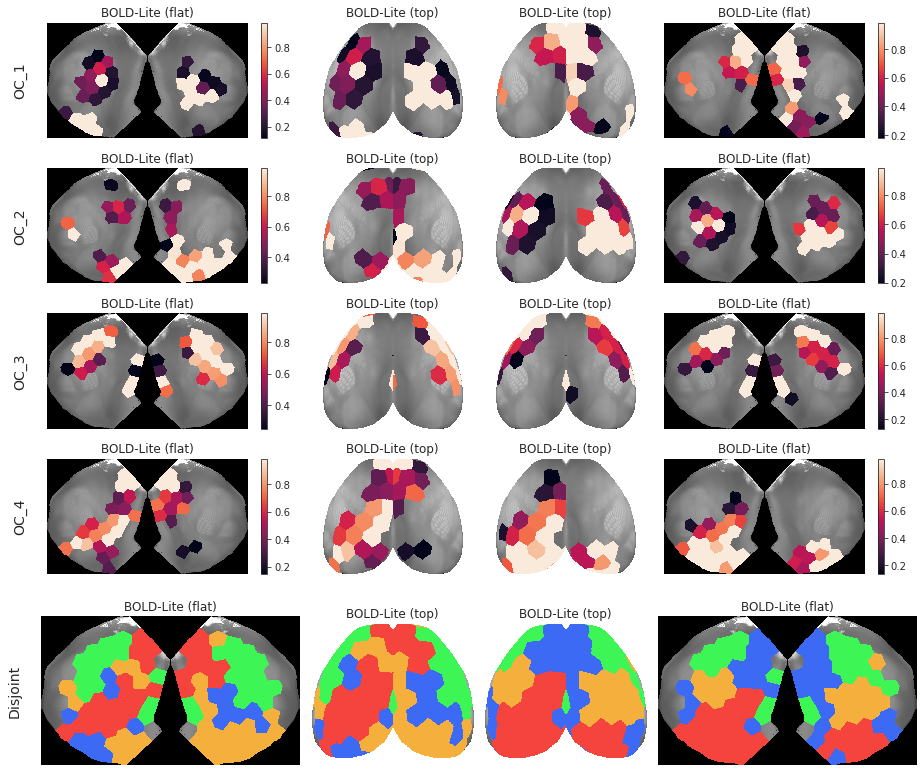

In [212]:
_disj = gr.get_disjoint_community(x, to_vec=True)
x = np.concatenate([x, np.expand_dims(_disj, 0)])
proj_x = gr.project_vec(x)

_disj = gr.get_disjoint_community(y, to_vec=True)
y = np.concatenate([y, np.expand_dims(_disj, 0)])
proj_y = gr.project_vec(y)

_ = gr.show(proj_x, proj_y, cmaps=('rocket', 'rocket'))

In [213]:
n_selected = 50
selected_seeds = np.argsort(dists_cos_mean)[:n_selected]

<AxesSubplot:ylabel='Count'>

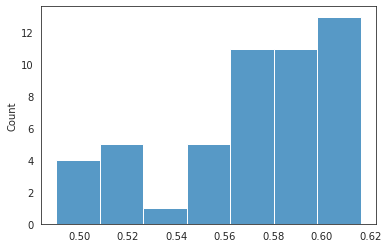

In [214]:
sns.histplot(dists_cos_mean[selected_seeds])

In [215]:
x = bn.nanmean(sv_bold.pi_all[np.argsort(dists_cos_mean)[:50]], 0)
y = bn.nanmean(sv_bold.pi_all[np.argsort(dists_cos_mean)[::-1][:50]], 0)

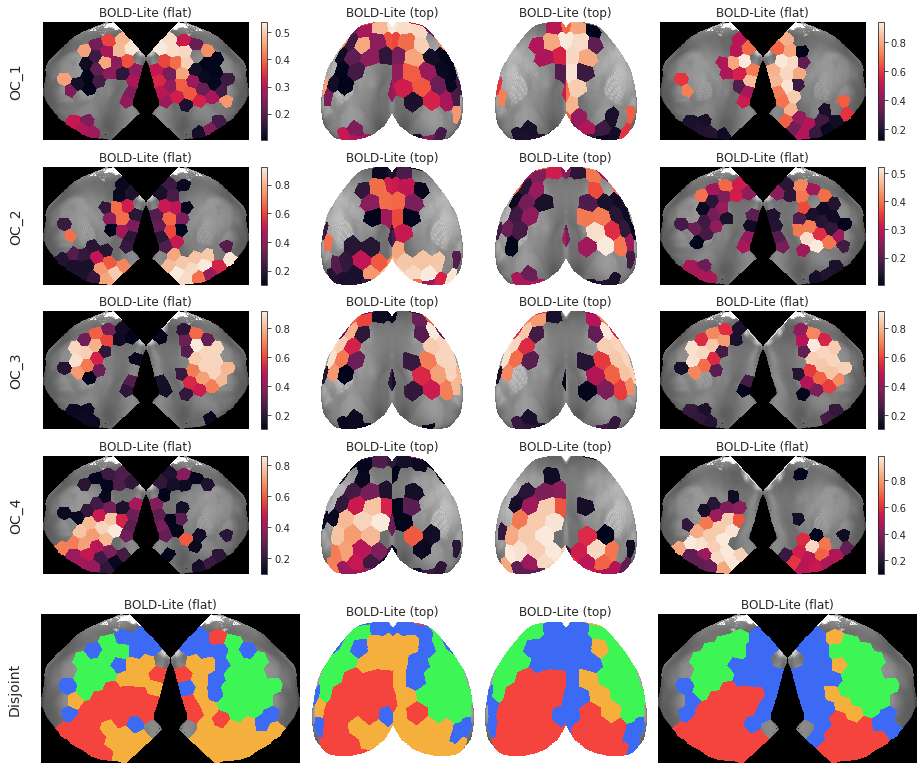

In [216]:
_disj = gr.get_disjoint_community(x, to_vec=True)
x = np.concatenate([x, np.expand_dims(_disj, 0)])
proj_x = gr.project_vec(x)

_disj = gr.get_disjoint_community(y, to_vec=True)
y = np.concatenate([y, np.expand_dims(_disj, 0)])
proj_y = gr.project_vec(y)

_ = gr.show(proj_x, proj_y, cmaps=('rocket', 'rocket'))

## Get group results

In [217]:
gr = Group(mode='ca2', centroids_from='all', **props_ca)
group_ca = gr.fit_group(skip_align=False)

gr = Group(mode='bold-lite', centroids_from='all', **props_bold)
group_bold = gr.fit_group(skip_align=False)

In [218]:
np.isnan(group_ca['gam_run'][9, 2]).sum() / np.prod(group_ca['gam_run'][9, 2].shape)

1.0

In [219]:
bins = np.linspace(0.2, 1.0, 5)

statistic = mk_statistic_fn(
    bins=bins,
    est_sub=bn.nanmean,
    est_ses=bn.nanmean,
    est_run=bn.nanmean,
    est_seed=bn.nanmedian,
    scipy=False,
)

In [220]:
output_ca = statistic(group_ca['gam_run'])
output_bold = statistic(group_bold['gam_run'])

In [221]:
list(output_ca)

['pi_anim', 'cut_anim', 'pi_group', 'cut_group']

<matplotlib.colorbar.Colorbar object at 0x7fe8d84d7b20>

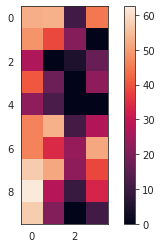

In [222]:
plt.imshow(output_ca['cut_anim'][..., -1])
plt.colorbar()

In [223]:
df = pd.DataFrame(dict(enumerate(output_ca['cut_anim'][..., -1]))).stack().reset_index()
df.head()

level_0 
 level_1 
 0 
 
 
 
 
 0 
 0 
 0 
 52.631579 
 
 
 1 
 0 
 1 
 48.717949 
 
 
 2 
 0 
 2 
 27.027027 
 
 
 3 
 0 
 3 
 40.540541 
 
 
 4 
 0 
 4 
 22.500000

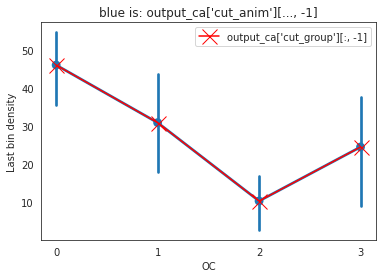

In [224]:
sns.pointplot(data=df, x='level_0', y=0, ci=99)
plt.plot(output_ca['cut_group'][:, -1], color='red', marker='x',
         markersize=15, label="output_ca['cut_group'][:, -1]")
plt.xlabel('OC')
plt.ylabel('Last bin density')
plt.legend()
plt.title('blue is: ' + "output_ca['cut_anim'][..., -1]")
plt.show()

In [225]:
ner = Normalizer()

In [226]:
dists = np.zeros((500, 5, 5))
dists_mean = np.zeros(500)
for seed_i in range(500):
    d = sp_dist.cdist(
        XA=centroids[:, nonan_consencus],
        XB=a_normed[seed_i][:, nonan_consencus],
        metric='euclidean',
    )
    dists[seed_i] = d
    dists_mean[seed_i] = np.diag(d).mean()

NameError: name 'nonan_consencus' is not defined

[<matplotlib.lines.Line2D object at 0x7f0d9e040ac0>]

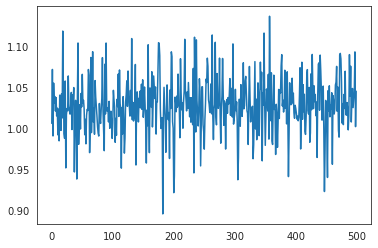

In [103]:
plt.plot(dists_mean)

<AxesSubplot:ylabel='Count'>

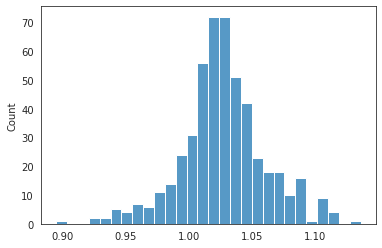

In [104]:
sns.histplot(dists_mean)

In [105]:
dists_cos = np.zeros((500, 5, 5))
dists_mean_cos = np.zeros(500)
for seed_i in range(500):
    d = sp_dist.cdist(
        XA=centroids[:, nonan_consencus],
        XB=a_normed[seed_i][:, nonan_consencus],
        metric='cosine',
    )
    dists_cos[seed_i] = d
    dists_mean_cos[seed_i] = np.diag(d).mean()

<AxesSubplot:ylabel='Count'>

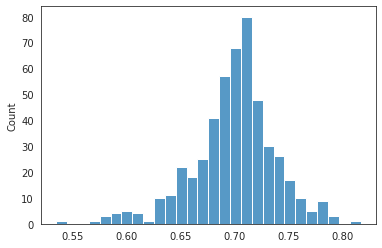

In [106]:
sns.histplot(dists_mean_cos)

<matplotlib.collections.PathCollection object at 0x7f0d97d44610>

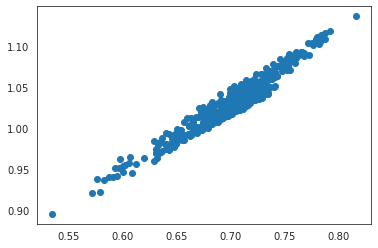

In [107]:
plt.scatter(x=dists_mean_cos, y=dists_mean)

In [15]:
_disj = gr.get_disjoint_community(output_ca['pi_group'], to_vec=True)
pi_avg_with_disj_ca = np.concatenate([output_ca['pi_group'], np.expand_dims(_disj, 0)])
proj_ca = gr.project_vec(pi_avg_with_disj_ca)

_disj = gr.get_disjoint_community(output_bold['pi_group'], to_vec=True)
pi_avg_with_disj_bold = np.concatenate([output_bold['pi_group'], np.expand_dims(_disj, 0)])
proj_bold = gr.project_vec(pi_avg_with_disj_bold)

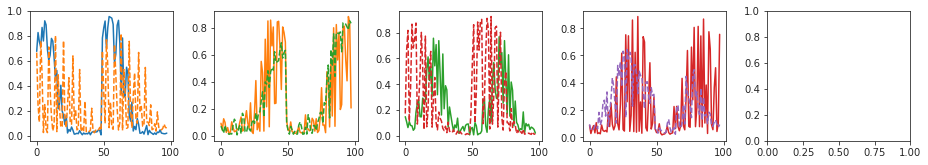

In [109]:
fig, axes = create_figure(1, 5, (13, 2.4))

for i, ax in enumerate(axes.flat):
    try:
        ax.plot(output_ca['pi_group'][i], color=f'C{i}')
        ax.plot(output_bold['pi_group'][i], color=f'C{i+1}', ls='--')
    except IndexError:
        continue
plt.show()

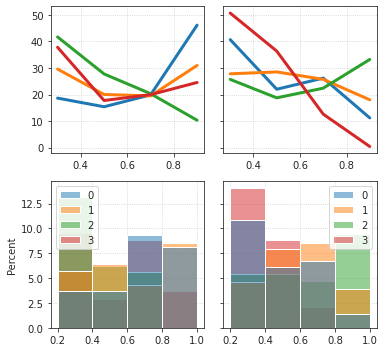

In [110]:
fig, axes = create_figure(2, 2, (5.5, 5), sharey='row')

axes[0, 0].plot((bins[:-1] + bins[1:]) / 2, output_ca['cut_group'].T, lw=3)
axes[0, 1].plot((bins[:-1] + bins[1:]) / 2, output_bold['cut_group'].T, lw=3)

sns.histplot(output_ca['pi_group'].T, bins=bins, stat='percent', ax=axes[1, 0])
sns.histplot(output_bold['pi_group'].T, bins=bins, stat='percent', ax=axes[1, 1])

for ax in axes.flat:
    ax.grid()

plt.show()

In [111]:
statistic_scipy = mk_statistic_fn(
    bins=bins,
    est_sub=bn.nanmean,
    est_ses=bn.nanmean,
    est_run=bn.nanmean,
    est_seed=bn.nanmedian,
    scipy=True,
)

In [30]:
%%time

n_resamples = 1000
batch = 5

_boot = sp_stats.bootstrap(
    data=(group_ca['gam_run'],),
    statistic=statistic_scipy,
    n_resamples=n_resamples,
    batch=batch,
    method='BCa',
    confidence_level=0.99,
    random_state=42,
    vectorized=True,
    axis=0,
)

CPU times: user 18min 40s, sys: 2min 39s, total: 21min 20s
Wall time: 21min 20s


- 50: 10mins
- 20: 4mins
- 10: 3min 38s
- 5: 3min 26s
- 3: 3min 22s
- 2: 3min 22 s

In [31]:
boot_ca = {
    'se': _boot.standard_error,
    'ci_low': _boot.confidence_interval.low,
    'ci_high': _boot.confidence_interval.high,
}
_ = save_obj(
    obj=boot_ca,
    file_name=f"boot_ca_{n_resamples}_{now()}",
    save_dir=tmp_dir,
    mode='npy',
)

[PROGRESS] 'boot_ca_1000_(2021_11_17).npy' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp

In [117]:
def mk_statistic_fn(
        bins: np.ndarray,
        est_sub: Callable,
        est_ses: Callable,
        est_run: Callable,
        est_seed: Callable,
        scipy: bool = False,
        # filter_nans: bool = True,
        verbose: bool = False, ) -> Callable:
    """
    Assumes input is Gamma:
        All results arranged in one 7-dim tensor. Has shape
        N_sub x N_ses x N_run x N_seed x K x N, where
        - N_sub = number of subjects
        - N_ses = number of sessions
        - N_run = number of runs
        - N_seed = number of seeds
        - K = number of communities
        - N = number of nodes (ROIs)
    :param bins:
    :param est_sub:
    :param est_ses:
    :param est_run:
    :param est_seed:
    :param scipy: if true, the statistic can be used with SciPy's BCa
    # :param filter_nans:
    :param verbose:
    :return:
    """

    def _calculate_pi(x, axis_ses, axis_run, axis_seed, axis_comm):
        return pi_from_gam(
            gam=x,
            axis_ses=axis_ses,
            axis_run=axis_run,
            axis_seed=axis_seed,
            axis_comm=axis_comm,
            est_ses=est_ses,
            est_run=est_run,
            est_seed=est_seed,
        )

    if not scipy:
        def _statistic(x):
            # calculate pi per animals
            if x.ndim == 6:	   # no batch dimension
                pi = _calculate_pi(x, 1, 2, -3, -2)
            elif x.ndim == 7:  # with batch at 0-th
                pi = _calculate_pi(x, 2, 3, -3, -2)
            else:
                msg = f"invalid shape: {x.shape}"
                raise RuntimeError(msg)
            # cut and calculate group average
            k, n = pi.shape[-2:]
            cut, _ = cut_data(
                data=pi.reshape(-1, k, n),
                bins=bins,
                oc_only=True,
            )
            cut = cut.reshape((*pi.shape[:-2], k, -1))
            # pi_avg = est_sub(pi, axis=-3)
            # cut_avg, _ = cut_data(
            # 	data=pi_avg,
            # 	bins=bins,
            # 	oc_only=True,
            # )
            output = {
                'pi_anim': pi,
                'cut_anim': cut,
                'pi_group': est_sub(pi, axis=-3),  # pi_avg,  # est_sub(pi, axis=-3)
                'cut_group': est_sub(cut, axis=-3),  # cut_avg,  # est_sub(cut, axis=-3)
                # TODO: this 'cut_group': cut_avg, does not mean anytihng,
                #  correct is cut_group = bn.nanmean(cut, 0)
            }
            return output
        return _statistic

    else:
        def _statistic(x, axis=None):
            if verbose:
                start = time()
            else:
                start = None
            pi = _calculate_pi(x, 0, 1, 2, 2)
            k, n = pi.shape[:2]
            cut, _ = cut_data(
                data=pi.reshape(k, n, -1),
                bins=bins,
                axis_oc=0,
                axis_node=1,
                axis_batch=-1,
                oc_only=True,
            )
            cut = cut.reshape((k, -1, *pi.shape[2:]))
            cut = bn.nanmean(cut, axis)
            cut += np.random.randn(*cut.shape) * 1e-3
           #  if cut.ndim == 3:
          #  #      for i in range(cut.shape[-1]):
         #            print(f"sample # {i}.\n", cut[..., -1])
         #    else:
        #         print(f"(Real?)", cut)
        #     print('\n')
             
            # if filter_nans:
            # 	cut[np.isnan(cut)] = 0.
            if verbose:
                print(convert_time(time() - start, verbose=False))
            return cut

        return _statistic

In [118]:
statistic_scipy = mk_statistic_fn(
    bins=bins,
    est_sub=bn.nanmean,
    est_ses=bn.nanmean,
    est_run=bn.nanmean,
    est_seed=bn.nanmedian,
   # filter_nans=True,
    scipy=True,
)

In [119]:
%%time

n_resamples = 300

_boot = sp_stats.bootstrap(
    data=(group_bold['gam_run'],),
    statistic=statistic_scipy,
    n_resamples=n_resamples,
    batch=7,# batch,
    method='BCa',
    confidence_level=0.99,
    random_state=42,
    vectorized=True,
    axis=0,
)
boot_bold = {
    'se': _boot.standard_error,
    'ci_low': _boot.confidence_interval.low,
    'ci_high': _boot.confidence_interval.high,
}
_ = save_obj(
    obj=boot_bold,
    file_name=f"boot_bold_{n_resamples}_{now()}",
    save_dir=tmp_dir,
    mode='npy',
)

[PROGRESS] 'boot_bold_300_(2021_11_17).npy' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp

CPU times: user 5min 8s, sys: 37.2 s, total: 5min 45s
Wall time: 5min 45s


In [101]:
np.percentile(np.zeros(20), 0.2)

0.0

In [98]:
output_bold['cut_group']

array([[34.2077172 , 25.42659587, 27.72795094, 12.63773599],
       [36.39535782, 30.29156055, 26.4032443 ,  6.90983734],
       [32.70318082, 22.0980216 , 21.08659638, 24.1122012 ],
       [82.26102056, 16.35151506,  1.38746439,  0.        ],
       [56.36665189, 33.98907901,  9.4519614 ,  0.19230769]])

In [49]:
test = np.transpose(group_bold['gam_run'], (1, 2, 3, 4, 5, 0))
test.shape

(3, 4, 500, 5, 146, 10)

In [50]:
statistic_scipy(test, -1)

array([[34.2077172 , 25.42659587, 27.72795094, 12.63773599],
       [36.39535782, 30.29156055, 26.4032443 ,  6.90983734],
       [32.70318082, 22.0980216 , 21.08659638, 24.1122012 ],
       [82.26102056, 16.35151506,  1.38746439,  0.        ],
       [56.36665189, 33.98907901,  9.4519614 ,  0.19230769]])

In [38]:
np.transpose(group_bold['gam_run'], (1, 2, 3, 4, 5, 0)).shape

(3, 4, 500, 5, 146, 10)

### Actual boot

In [123]:
%%time

gam_booted = collections.defaultdict(list)
for i in tqdm(range(10)):
    _ca, _bold = bootstrap(
            x=[group_ca['gam_run'], group_bold['gam_run']],
            rng=get_rng(i),
            batch=5,
        )
    gam_booted['ca'].append(_ca)
    gam_booted['bold'].append(_bold)

gam_booted = {
    k: np.concatenate(v) for
    k, v in gam_booted.items()
}
{k: v.shape for k, v in gam_booted.items()}

  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: user 1min 20s, sys: 13.2 s, total: 1min 33s
Wall time: 1min 33s


{'ca': (50, 10, 3, 4, 5, 146), 'bold': (50, 10, 3, 4, 5, 146)}

In [124]:
#statistic = mk_statistic_fn(bins, bn.nanmean, bn.nanmean, bn.nanmean, None,)

output_booted_ca = statistic(np.expand_dims(gam_booted['ca'], -3))
output_booted_bold = statistic(np.expand_dims(gam_booted['bold'], -3))
output_booted_ca['cut_anim'].shape, output_booted_bold['cut_anim'].shape

((50, 10, 5, 4), (50, 10, 5, 4))

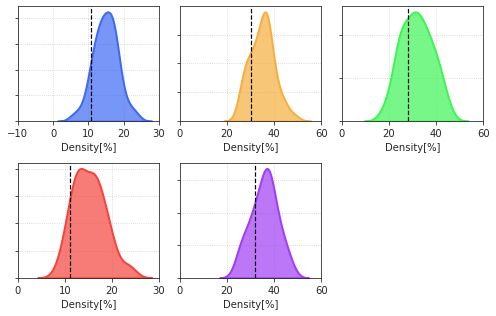

In [126]:
fig, axes = create_figure(2, 3, (7, 4.5))
for i, ax in enumerate(axes.flat):
    try:
        data = output_booted_ca['cut_group'][:, i, -1]
        # data = coutput_booted_ca['cut_group'][:, i, -1]
        mean = bn.nanmean(output_ca['cut_anim'], 0)[i, -1]
    except IndexError:
        continue
    ax.axvline(mean, color='k', ls='--', lw=1.2)
    sns.kdeplot(
        data=data, ax=ax, color=gr.colors[i+1], shade=True,
        alpha=0.7, lw=2.,
    )
    xticks = ax.get_xticks()
    ax.set_xticks([e for e in xticks if int(e) == np.round(e, 1)])
    ax.tick_params(axis='y', labelleft=False)
    ax.set_xlabel('Density[%]')
    ax.set_ylabel('')
    ax.grid()
trim_axs(axes, gr.num_k)
plt.show()

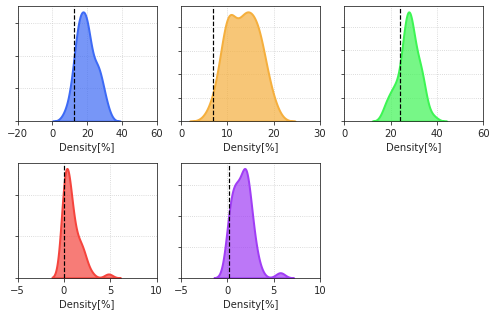

In [127]:
fig, axes = create_figure(2, 3, (7, 4.5))
for i, ax in enumerate(axes.flat):
    try:
        data = output_booted_bold['cut_group'][:, i, -1]
        # data = coutput_booted_bold['cut_group'][:, i, -1]
        mean = bn.nanmean(output_bold['cut_anim'], 0)[i, -1]
    except IndexError:
        continue
    ax.axvline(mean, color='k', ls='--', lw=1.2)
    sns.kdeplot(
        data=data, ax=ax, color=gr.colors[i+1], shade=True,
        alpha=0.7, lw=2.,
    )
    xticks = ax.get_xticks()
    ax.set_xticks([e for e in xticks if int(e) == np.round(e, 1)])
    ax.tick_params(axis='y', labelleft=False)
    ax.set_xlabel('Density[%]')
    ax.set_ylabel('')
    ax.grid()
trim_axs(axes, gr.num_k)
plt.show()

## Memberships on cortex

In [227]:
_disj = gr.get_disjoint_community(output_ca['pi_group'], to_vec=True)
pi_avg_with_disj_ca = np.concatenate([output_ca['pi_group'], np.expand_dims(_disj, 0)])
proj_ca = gr.project_vec(pi_avg_with_disj_ca)

_disj = gr.get_disjoint_community(output_bold['pi_group'], to_vec=True)
pi_avg_with_disj_bold = np.concatenate([output_bold['pi_group'], np.expand_dims(_disj, 0)])
proj_bold = gr.project_vec(pi_avg_with_disj_bold)

In [228]:
fig, _ = gr.show(
    proj_bold, proj_ca,
    labels=('BOLD-Lite', r'CA$^{2+}$'),
    cmaps=('rocket', 'mako'),
    display=False,
)
sup = f"BOLD-Lite:   k{props_bold.get('num_k')} / {props_bold.get('perc')},          "
sup += r"CA$^{2+}$:   " + f"k{props_ca.get('num_k')} / {props_ca.get('perc')}"
sup = fig.suptitle(sup, fontsize=18, y=1.02)

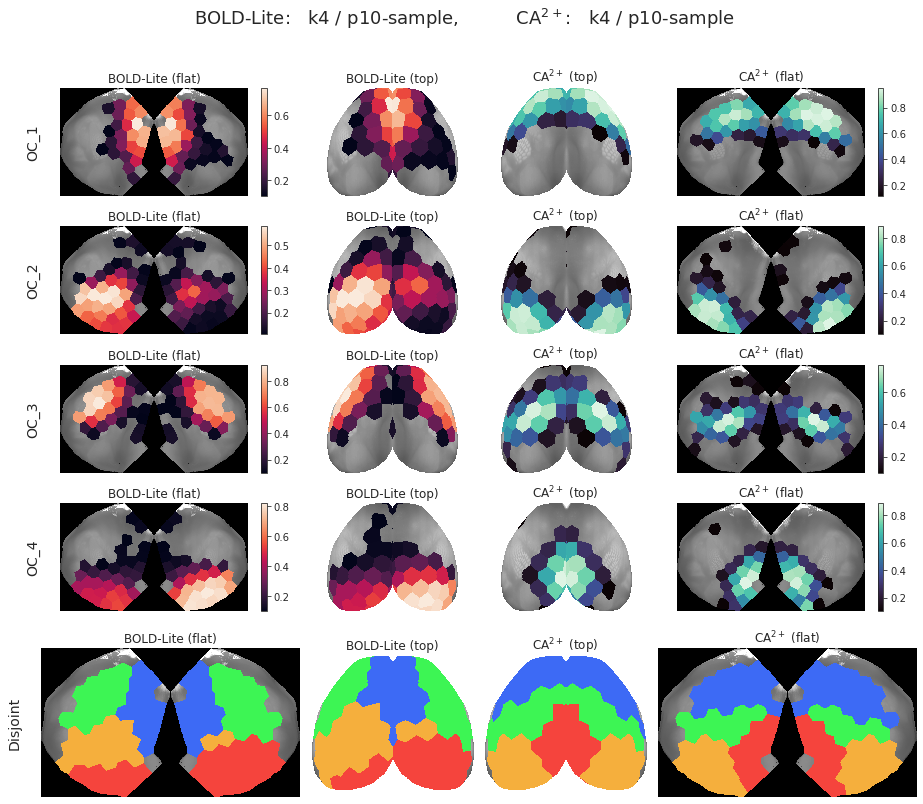

In [229]:
fig

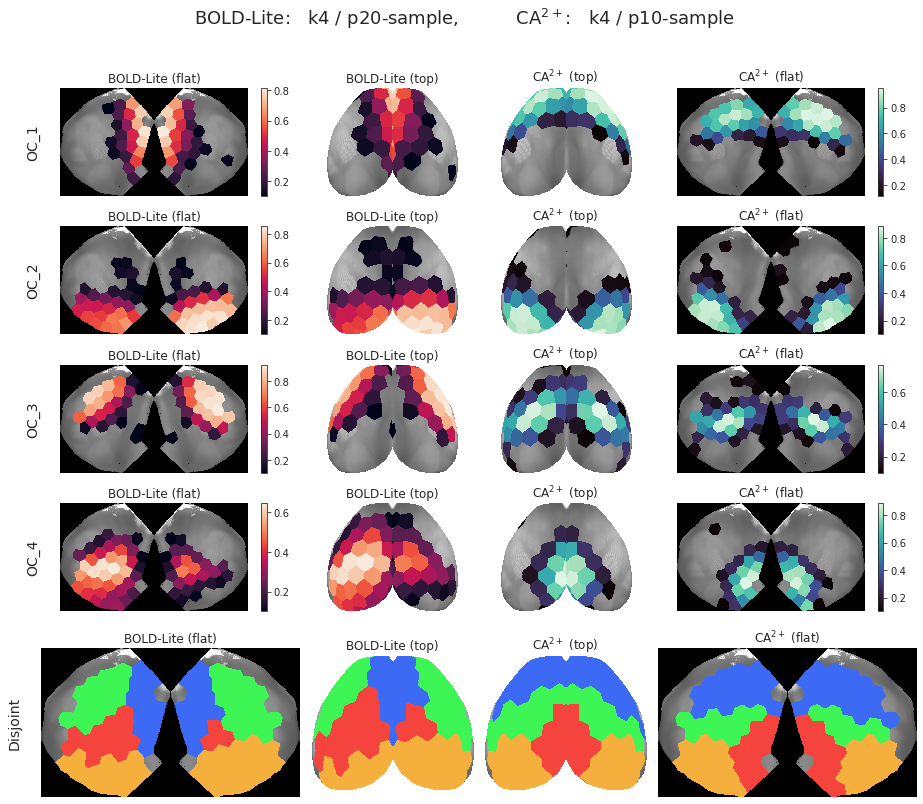

In [66]:
sv_ca = SVINET(key='sub-SLC', mode='ca2', **props_ca).load_results()
sv_bold = SVINET(key='sub-SLC', mode='bold-lite', **props_bold).load_results()

sv_ca.pi.shape, sv_bold.pi.shape

((5, 146), (5, 146))

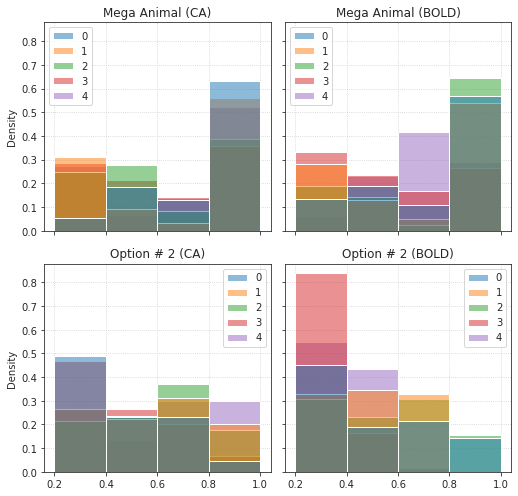

In [70]:
fig, axes = create_figure(2, 2, (7.3, 7), sharex='all', sharey='all')

sns.histplot(sv_ca.pi.T, bins=bins, stat='density', ax=axes[0, 0])
sns.histplot(sv_bold.pi.T, bins=bins, stat='density', ax=axes[0, 1])

sns.histplot(output_ca['pi_group'].T, bins=bins, stat='density', ax=axes[1, 0])
sns.histplot(output_bold['pi_group'].T, bins=bins, stat='density', ax=axes[1, 1])

axes[0, 0].set_title('Mega Animal (CA)')
axes[0, 1].set_title('Mega Animal (BOLD)')
axes[1, 0].set_title('Option # 2 (CA)')
axes[1, 1].set_title('Option # 2 (BOLD)')

for ax in axes.flat:
    ax.grid()

plt.show()

In [114]:
disjoint = gr.get_disjoint_community(sv_ca.pi, to_vec=True)
pi_ca = np.concatenate([sv_ca.pi, np.expand_dims(disjoint, 0)])
proj_ca = gr.project_vec(pi_ca)

disjoint = gr.get_disjoint_community(sv_bold.pi, to_vec=True)
pi_bold = np.concatenate([sv_bold.pi, np.expand_dims(disjoint, 0)])
proj_bold = gr.project_vec(pi_bold)

In [72]:
fig, _ = gr.show(
    proj_bold, proj_ca,
    labels=('BOLD-Lite', r'CA$^{2+}$'),
    cmaps=('rocket', 'mako'),
    display=False,
)
sup = 'Mega Animal\n'
sup += f"BOLD-Lite:   k{props_bold.get('num_k')} / {props_bold.get('perc')},          "
sup += r"CA$^{2+}$:   " + f"k{props_ca.get('num_k')} / {props_ca.get('perc')}"
sup = fig.suptitle(sup, fontsize=18, y=1.02)

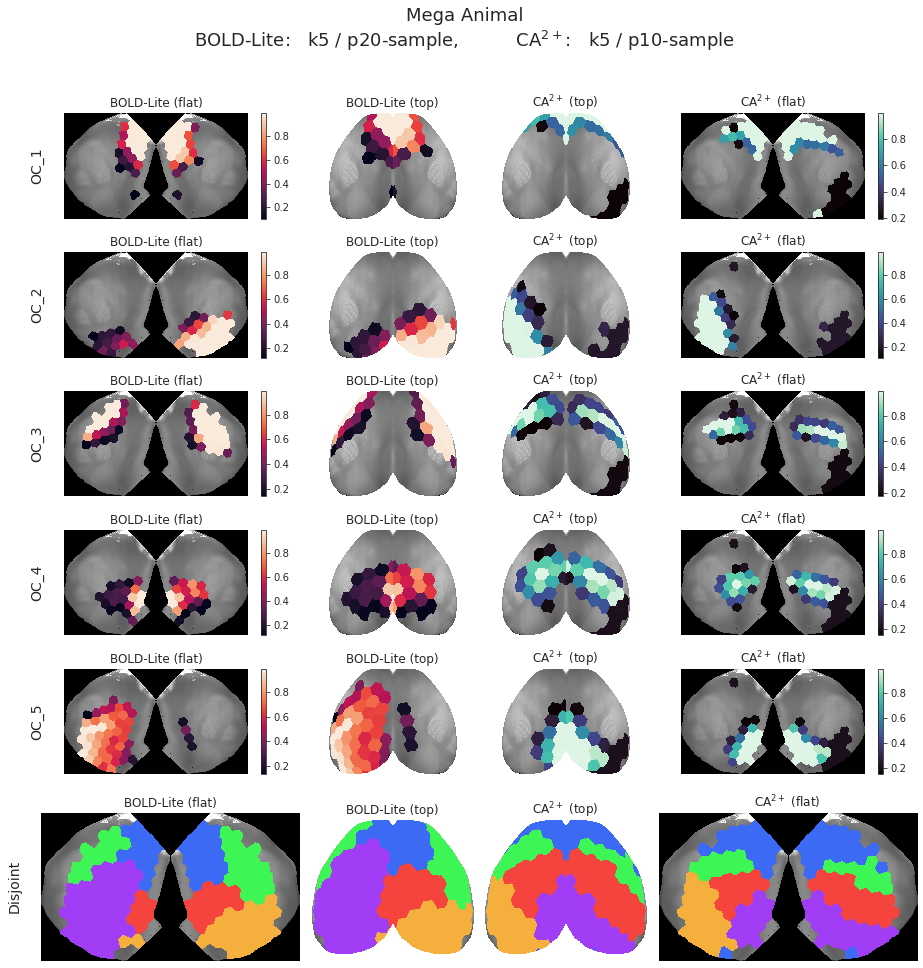

In [73]:
fig

In [77]:
dlist = []
for i in range(gr.num_k):
    for j, intvl in enumerate(gr.intervals):
        dlist.append({
            'interval': [intvl] * len(output_ca['cut_anim']),
            'oc_idx': [i + 1] * len(output_ca['cut_anim']),
            'color': [gr.colors[i + 1]] * len(output_ca['cut_anim']),
            'subject': range(len(output_ca['cut_anim'])),
            'mean': output_ca['cut_anim'][:, i, j],
            'se': [boot_ca['se'][i, j]] * len(output_ca['cut_anim']),
        })
df_ca = pd.DataFrame(merge_dicts(dlist))

In [78]:
df_ca

interval 
 oc_idx 
 color 
 subject 
 mean 
 se 
 
 
 
 
 0 
 (0.2, 0.4] 
 1 
 #3d6af5 
 0 
 50.000000 
 2.925415 
 
 
 1 
 (0.2, 0.4] 
 1 
 #3d6af5 
 1 
 31.818182 
 2.925415 
 
 
 2 
 (0.2, 0.4] 
 1 
 #3d6af5 
 2 
 41.025641 
 2.925415 
 
 
 3 
 (0.2, 0.4] 
 1 
 #3d6af5 
 3 
 49.056604 
 2.925415 
 
 
 4 
 (0.2, 0.4] 
 1 
 #3d6af5 
 4 
 38.297872 
 2.925415 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 195 
 (0.8, 1.0] 
 5 
 #a03df5 
 5 
 57.575758 
 5.868328 
 
 
 196 
 (0.8, 1.0] 
 5 
 #a03df5 
 6 
 57.575758 
 5.868328 
 
 
 197 
 (0.8, 1.0] 
 5 
 #a03df5 
 7 
 48.484848 
 5.868328 
 
 
 198 
 (0.8, 1.0] 
 5 
 #a03df5 
 8 
 25.714286 
 5.868328 
 
 
 199 
 (0.8, 1.0] 
 5 
 #a03df5 
 9 
 27.027027 
 5.868328 
 
 
 
 200 rows × 6 columns

In [132]:
figs, sups, axes, axes_inset = plot_group(
    df_real=df_ca,
    inset_kind='kde',
    inset_data=output_booted_ca['cut_group'][..., -1].T,
    save_file=pjoin(tmp_dir, f"Fig-1_CA2_{now()}.pdf"),
)

/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/Fig-1_CA2_(2021_11_17).pdf

done.

In [3]:
mice = Mice((100, 3))
mice.setup_func_data('rest')

In [4]:
props_base = {
    'num_k': 5,
    'mice': mice,
    'task': 'rest',
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'prepare_data': False,
    'verbose': False,
}
props_ca = {'perc': 'p10-sample', **props_base}
props_bold = {'perc': 'p20-sample', **props_base}

In [25]:
gr = Group(mode='ca2', centroids_from='all', **props_ca)
# gr = Group(mode='bold-lite', centroids_from='all', **props_bold)

In [9]:
ner = Normalizer()

In [10]:
sub = 6
ses = 2
run = 7
key = mice.get_key(sub, ses, run)

sv_ca = SVINET(key=key, mode='ca2', **props_ca).load_results()
sv_bold = SVINET(key=key, mode='bold-lite', **props_bold).load_results()

sv_ca.pi.shape, sv_bold.pi.shape

((5, 146), (5, 146))

In [16]:
num_seeds, num_k, num_nodes = sv_ca.gam_all.shape
num_seeds, num_k, num_nodes

(500, 5, 146)

In [17]:
nonan = np.where(np.isnan(sv_ca.gam_all).sum(0).sum(0) == 0)[0]
len(nonan)

129

In [20]:
data = sv_ca.gam_all.reshape(-1, num_nodes)
data.shape

(2500, 146)

In [21]:
centroids = np_nans((num_k, num_nodes))
_centroids, _ = fit_kmeans(
    data=data[:, nonan],
    n_clusters=num_k,
    match_metric='euclidean',
    random_state=mice.cfg.random_state,
)
centroids[:, nonan] = _centroids
centroids.shape

(5, 146)

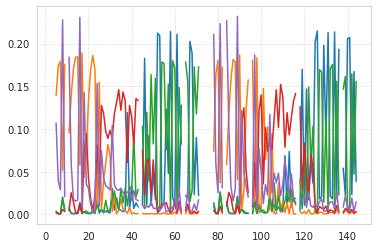

In [22]:
plt.plot(centroids.T);

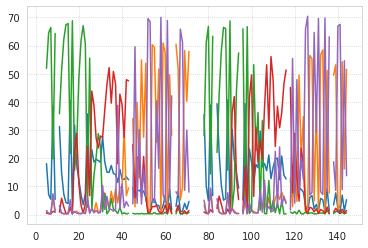

In [23]:
plt.plot(bn.nanmean(sv_ca.gam_all, 0).T);

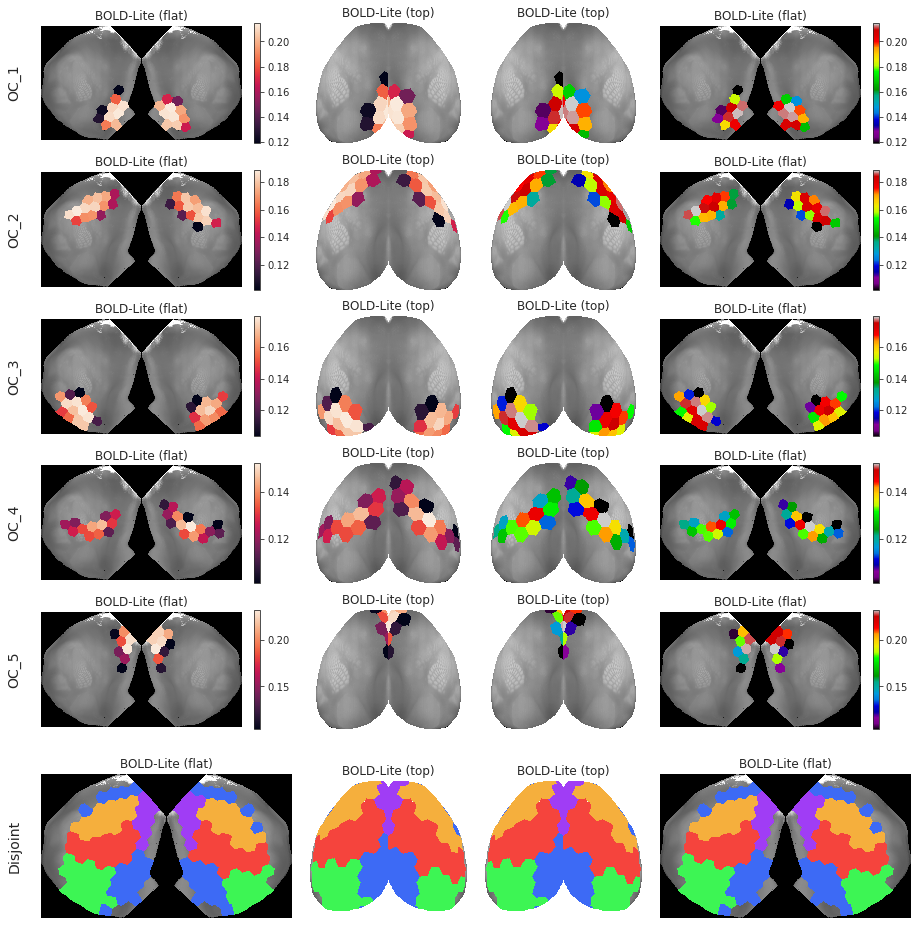

In [27]:
_disj = gr.get_disjoint_community(centroids, to_vec=True)
ctrds = np.concatenate([centroids, np.expand_dims(_disj, 0)])
proj_ctrds = gr.project_vec(ctrds)
_ = gr.show(proj_ctrds)

In [29]:
gam_normed = np.zeros_like(sv_ca.gam_all)

for i in range(num_seeds):
    a = ner.fit_transform(sv_ca.gam_all[i][:, nonan])
    gam_normed[i][:, nonan] = a

In [31]:
dists = np.zeros((num_seeds, num_k, num_k))
dists_mean = np.zeros(num_seeds)
for seed_i in range(num_seeds):
    d = sp_dist.cdist(
        XA=centroids[:, nonan],
        XB=gam_normed[seed_i][:, nonan],
        metric='euclidean',
    )
    dists[seed_i] = d
    dists_mean[seed_i] = np.diag(d).mean()

In [33]:
dists_cos = np.zeros((num_seeds, num_k, num_k))
dists_cos_mean = np.zeros(num_seeds)
for seed_i in range(num_seeds):
    d = sp_dist.cdist(
        XA=centroids[:, nonan],
        XB=gam_normed[seed_i][:, nonan],
        metric='cosine',
    )
    dists_cos[seed_i] = d
    dists_cos_mean[seed_i] = np.diag(d).mean()

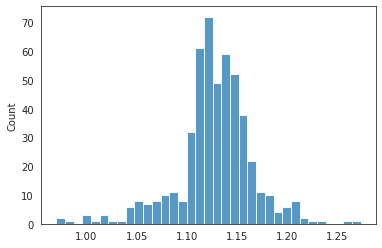

In [34]:
sns.histplot(dists_mean);

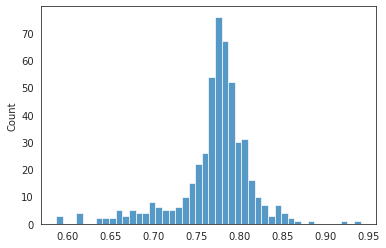

In [36]:
sns.histplot(dists_cos_mean);

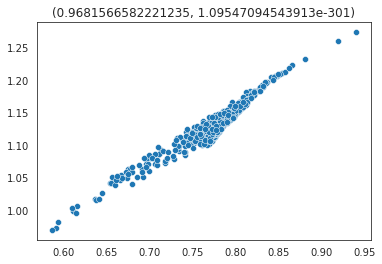

In [40]:
sns.scatterplot(dists_cos_mean, dists_mean)
plt.title(sp_stats.pearsonr(dists_cos_mean, dists_mean));

In [49]:
x = sv_ca.gam_all[np.argmin(dists_cos_mean)]
y = sv_ca.gam_all[np.argmax(dists_cos_mean)]

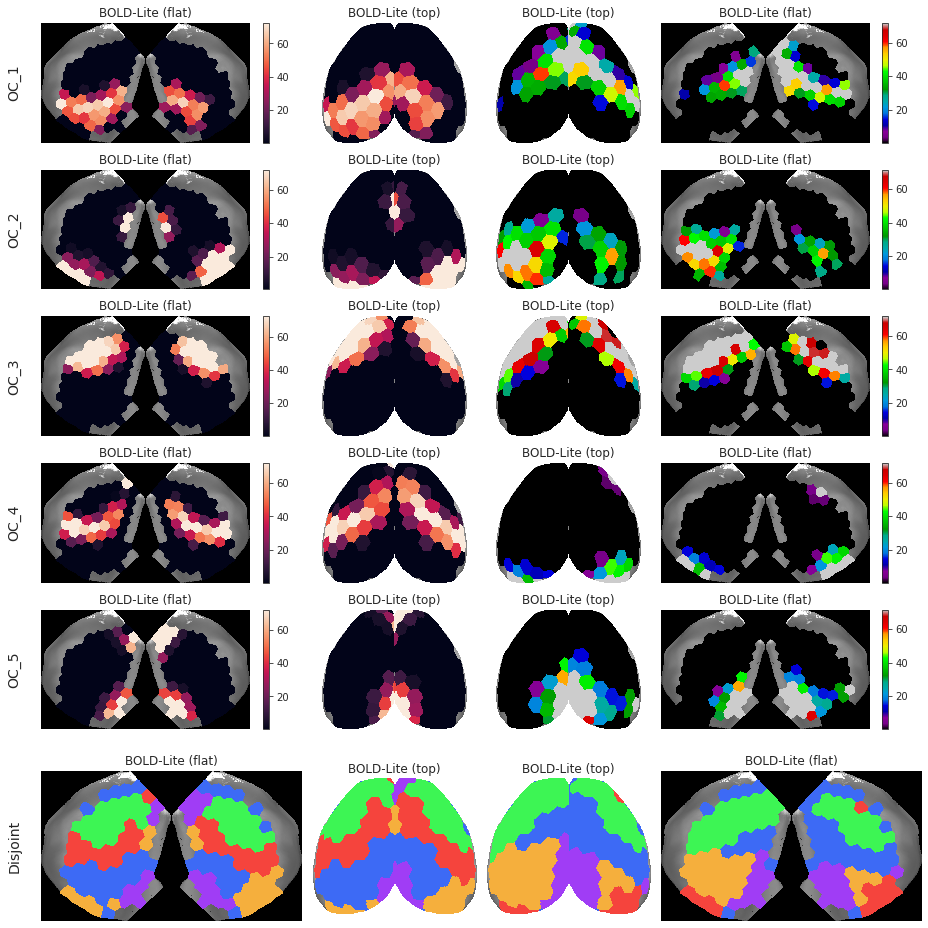

In [50]:
_disj = gr.get_disjoint_community(x, to_vec=True)
x = np.concatenate([x, np.expand_dims(_disj, 0)])
proj_x = gr.project_vec(x)

_disj = gr.get_disjoint_community(y, to_vec=True)
y = np.concatenate([y, np.expand_dims(_disj, 0)])
proj_y = gr.project_vec(y)

_ = gr.show(proj_x, proj_y)

In [61]:
n_selected = 50
selected_seeds = np.argsort(dists_cos_mean)[:n_selected]

<AxesSubplot:ylabel='Count'>

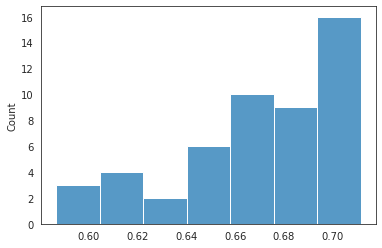

In [62]:
sns.histplot(dists_cos_mean[selected_seeds])

In [65]:
x = bn.nanmean(sv_ca.pi_all[np.argsort(dists_cos_mean)[:50]], 0)
y = bn.nanmean(sv_ca.pi_all[np.argsort(dists_cos_mean)[::-1][:50]], 0)

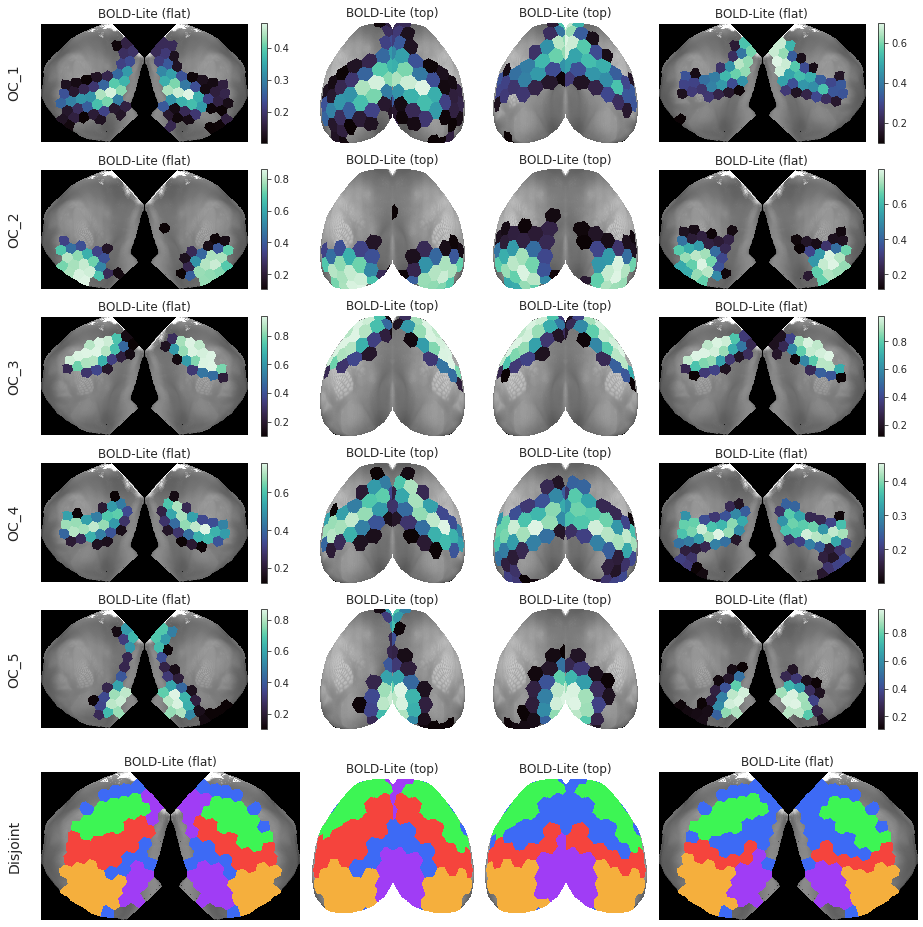

In [66]:
_disj = gr.get_disjoint_community(x, to_vec=True)
x = np.concatenate([x, np.expand_dims(_disj, 0)])
proj_x = gr.project_vec(x)

_disj = gr.get_disjoint_community(y, to_vec=True)
y = np.concatenate([y, np.expand_dims(_disj, 0)])
proj_y = gr.project_vec(y)

_ = gr.show(proj_x, proj_y, cmaps=('mako', 'mako'))

In [135]:
mice = Mice((100, 3))
mice.setup_func_data('rest')



props_base = {
    'num_k': 5,
    'mice': mice,
    'task': 'rest',
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'prepare_data': False,
    'verbose': False,
}
props_ca = {'perc': 'p10-sample', **props_base}
props_bold = {'perc': 'p20-sample', **props_base}



gr = Group(mode='ca2', centroids_from='all', **props_ca)
# gr = Group(mode='bold-lite', centroids_from='all', **props_bold)



ner = Normalizer()

sub = 6
ses = 2
run = 7
key = mice.get_key(sub, ses, run)

sv_ca = SVINET(key=key, mode='ca2', **props_ca).load_results()
sv_bold = SVINET(key=key, mode='bold-lite', **props_bold).load_results()

sv_ca.pi.shape, sv_bold.pi.shape



num_seeds, num_k, num_nodes = sv_ca.gam_all.shape
num_seeds, num_k, num_nodes

nonan = np.where(np.isnan(sv_ca.gam_all).sum(0).sum(0) == 0)[0]
len(nonan)



data = sv_ca.gam_all.reshape(-1, num_nodes)
data.shape

centroids = np_nans((num_k, num_nodes))
_centroids, _ = fit_kmeans(
    data=data[:, nonan],
    n_clusters=num_k,
    match_metric='euclidean',
    random_state=mice.cfg.random_state,
)
centroids[:, nonan] = _centroids
centroids.shape



plt.plot(centroids.T);

plt.plot(bn.nanmean(sv_ca.gam_all, 0).T);



_disj = gr.get_disjoint_community(centroids, to_vec=True)
ctrds = np.concatenate([centroids, np.expand_dims(_disj, 0)])
proj_ctrds = gr.project_vec(ctrds)
_ = gr.show(proj_ctrds)



gam_normed = np.zeros_like(sv_ca.gam_all)

for i in range(num_seeds):
    a = ner.fit_transform(sv_ca.gam_all[i][:, nonan])
    gam_normed[i][:, nonan] = a



dists = np.zeros((num_seeds, num_k, num_k))
dists_mean = np.zeros(num_seeds)
for seed_i in range(num_seeds):
    d = sp_dist.cdist(
        XA=centroids[:, nonan],
        XB=gam_normed[seed_i][:, nonan],
        metric='euclidean',
    )
    dists[seed_i] = d
    dists_mean[seed_i] = np.diag(d).mean()

dists_cos = np.zeros((num_seeds, num_k, num_k))
dists_cos_mean = np.zeros(num_seeds)
for seed_i in range(num_seeds):
    d = sp_dist.cdist(
        XA=centroids[:, nonan],
        XB=gam_normed[seed_i][:, nonan],
        metric='cosine',
    )
    dists_cos[seed_i] = d
    dists_cos_mean[seed_i] = np.diag(d).mean()

sns.histplot(dists_mean);

sns.histplot(dists_cos_mean);

sns.scatterplot(dists_cos_mean, dists_mean)
plt.title(sp_stats.pearsonr(dists_cos_mean, dists_mean));



x = sv_ca.gam_all[np.argmin(dists_cos_mean)]
y = sv_ca.gam_all[np.argmax(dists_cos_mean)]

_disj = gr.get_disjoint_community(x, to_vec=True)
x = np.concatenate([x, np.expand_dims(_disj, 0)])
proj_x = gr.project_vec(x)

_disj = gr.get_disjoint_community(y, to_vec=True)
y = np.concatenate([y, np.expand_dims(_disj, 0)])
proj_y = gr.project_vec(y)

_ = gr.show(proj_x, proj_y)



n_selected = 50
selected_seeds = np.argsort(dists_cos_mean)[:n_selected]

sns.histplot(dists_cos_mean[selected_seeds])



x = bn.nanmean(sv_ca.pi_all[np.argsort(dists_cos_mean)[:50]], 0)
y = bn.nanmean(sv_ca.pi_all[np.argsort(dists_cos_mean)[::-1][:50]], 0)

_disj = gr.get_disjoint_community(x, to_vec=True)
x = np.concatenate([x, np.expand_dims(_disj, 0)])
proj_x = gr.project_vec(x)

_disj = gr.get_disjoint_community(y, to_vec=True)
y = np.concatenate([y, np.expand_dims(_disj, 0)])
proj_y = gr.project_vec(y)

_ = gr.show(proj_x, proj_y, cmaps=('mako', 'mako'))

dlist = []
for i in range(gr.num_k):
    for j, intvl in enumerate(gr.intervals):
        dlist.append({
            'interval': [intvl] * len(output_bold['cut_anim']),
            'oc_idx': [i + 1] * len(output_bold['cut_anim']),
            'color': [gr.colors[i + 1]] * len(output_bold['cut_anim']),
            'subject': range(len(output_bold['cut_anim'])),
            'mean': output_bold['cut_anim'][:, i, j],
            'se': [boot_bold['se'][i, j]] * len(output_bold['cut_anim']),
        })
df_bold = pd.DataFrame(merge_dicts(dlist))

In [137]:
figs, sups, axes, axes_inset = plot_group(
    df_real=df_bold,
    inset_kind='kde',
    inset_data=output_booted_bold['cut_group'][..., -1].T,
    save_file=pjoin(tmp_dir, f"Fig-1_BOLD_{now()}.pdf"),
)

/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/Fig-1_BOLD_(2021_11_17).pdf

done.